# Importing and Parameter Setting

In [12]:
#import packages
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import re
from scipy.spatial import distance
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import ward, fcluster
import numpy as np
from scipy import stats
import requests
import contextlib
import warnings
warnings.filterwarnings('ignore')

# Set plot settings

In [9]:
#set labelsize
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 
plt.rc('axes', labelsize=12) 
plt.style.use('ggplot')
plt.rcParams['svg.fonttype'] = 'none'

# Data Loading for the analysis 

In [10]:
#load databases for snoRNA evaluation
# this tsv is downloaded from https://bioinfo-scottgroup.med.usherbrooke.ca/snoDB/
snodb = pd.read_csv("/home/data-science/Desktop/overview_run_oixb41nf/snoRNA/snoDB.tsv", delimiter = "\t")

# Create Helper Functions

In [13]:
# z-score the timelined expression values
from scipy import stats

def z_score_dataset(network_df: pd.DataFrame) -> pd.DataFrame:
    
    """input is the dataframe with vst counts
    output -> z-score normalization along the rows 
    args:
        network_df (pd.DataFrame) <- holds the expression data
    returns:
        stats_z (pd.DataFrame) <- zscored representation of the data
    """
    stats_z = network_df.values.astype(float)
    stats_z = stats.zscore(stats_z, axis=1)
    stats_end = pd.DataFrame(stats_z, index=network_df.index)
    stats_end.index = [i.split(":")[0] for i in stats_end.index]
    return stats_end

In [14]:
def z_score_dataset_mrna(network_df: pd.DataFrame, colnames: list) -> pd.DataFrame:
    
    """input is the dataframe with vst counts
    output -> z-score normalization along the rows 
    args:
        network_df (pd.DataFrame) <- holds the expression data
        colnames <- specify the name of the final columns for visalizatoin
    returns:
        stats_z (pd.DataFrame) <- zscored representation of the data
    """
    stats_z = network_df.values.astype(float)
    stats_z = stats.zscore(stats_z, axis=1)
    stats_end = pd.DataFrame(stats_z, index=network_df.index)
    stats_end.columns = colnames
    stats_end = stats_end.sort_index(axis = 1)
    stats_end.index = [i.split(":")[0] for i in stats_end.index]
    return stats_end

In [34]:
def svd_scatter(df: pd.DataFrame,title: str):
    """_summary_: Singular Value Decomposition (SVD) scatter plot

    Args:
        df (pd.DataFrame): dataframe holding the vst count data
        title (str): Description of the Image
    """
    # 
    u, s, vh = np.linalg.svd(df.iloc[:, :-1].values)
    labels = [f'SV{str(i)}' for i in range(1, 3)]
    svd_df = pd.DataFrame(u[:, 0:2], columns=labels)
    svd_df["cluster"] = df["hierachical_cluster"].tolist()
    ax = plt.subplots(figsize=(6, 6))
    sns.despine()
    sns.scatterplot(data=svd_df,
                    x="SV1",
                    y="SV2",
                    hue="cluster",
                    legend="full",
                    palette="tab10",
                    linewidth=0,
                    s=20,
                    alpha=0.9)
    plt.xlabel("SVD1")
    plt.ylabel("SVD2")
    plt.title(title)
    plt.savefig(f"{title}.png", dpi=600, bbox_inches="tight")

In [16]:
# cluster using hierachical clustering average method
def hierachical_clustering(df_cluster: pd.DataFrame, threshold_cluster: float, label: str,label2: str) -> tuple:
    """
        defines the hierachical clustering of the data
        args:
            df_cluster (pd.DataFrame) <- dataframe holding the zscored expression data
            threshold_mRNA : threshold mRNA clustering after visualization
            threshold_miRNA : threhsold miRNA clustering after visualization
        """
    df = df_cluster.copy(deep= True)
    mRNA_correlation = np.asarray(df)

    # Define the hierachical linkage for rows and columns mRNA
    # can be easier by directly calling
    row_linkage_mRNA = hierarchy.linkage(distance.pdist(mRNA_correlation),'ward', "correlation")
    col_linkage_mRNA = hierarchy.linkage(distance.pdist(mRNA_correlation),method='ward')

    #get the cluster for miRNAs and mRNAs
    hierarchical_cluster_mRNA = fcluster(row_linkage_mRNA, threshold_cluster, "distance")

    #draw the dendograms
    fig, ax = plt.subplots(figsize=(15, 8))
    dn_mRNA = hierarchy.dendrogram(row_linkage_mRNA)
    plt.axhline(y=threshold_cluster, color='r', linestyle='-')
    #uncomment this to save the image of the hierachical clustering dendogramm
    #plt.savefig(label2 + ".pdf", dpi=400, transparent=True)

    #extract clusters and assign to all the tables
    all_mrna = df
    all_mrna["hierachical_cluster"] = hierarchical_cluster_mRNA

    # uncomment this to save the table with the cluster data
    #all_mrna.to_csv(label+ ".csv")
    return all_mrna, hierarchical_cluster_mRNA

In [17]:
# merge tables to get the padj and the base mean
def merge_tables(df1: pd.DataFrame, df2:pd.DataFrame) -> pd.DataFrame:
    """This creates a merge between the vst counts and the baseline DEG metric
    args:
        df1 (pd.DataFrame) <- basic metrics
        df2 (pd.DataFrame) <- vst counts
    returns:
        pd.DataFrame  A metrics table with all the necessary DEG metric"""
    df1["Row.names"] = [i.split(":")[0] for i in df1["Row.names"]]
    merge_table = pd.merge(df1, df2, how = "left", left_on = "Row.names", right_index = True)
    merge_table = merge_table[["Row.names","cluster","baseMean","padj"]]
    return merge_table

In [18]:
# retrieve the highest ranked ncRNAs per biotype and draws the log10 pvalue as well as the heatmap
def get_highest_ranked(df:pd.DataFrame, 
                       df_heatmap: pd.DataFrame,
                       circRNA: bool = False, 
                       n_largest: int = 2,
                       title: str = "Analysis") -> None:
    """ function to get the highest significantly dysregulated ncRNAs per group"""
    # preprocess the table for drawing 
    df["log10p"] = df["padj"].apply(lambda x: -(np.log10(x))) # transform p-value to log10 scale for ranking
    highest_expressed = pd.DataFrame(df.set_index("Row.names").groupby(["cluster"])["log10p"].nlargest(n_largest)) # rank and group
    highest_expressed = highest_expressed.reset_index() 
    highest_expressed = pd.merge(highest_expressed, df_heatmap, how = "left", left_on = "Row.names", right_index = True)
    # for circRNAs 
    if circRNA:
        highest_expressed["Row.names"] = [i.split("|")[0] for i in highest_expressed["Row.names"]]
    df_heatmap_final = highest_expressed.set_index("Row.names")
    draw_highest_ranked(highest_expressed, df_heatmap_final, title)
    
def draw_highest_ranked(highest_expressed: pd.DataFrame, df_heatmap: pd.DataFrame, title: str):
    """ Draws the combined plot between heatmap and """
    # initialize the figure
    fig,ax = plt.subplots(figsize = (7,5),
                          ncols = 2,
                          nrows = 1,
                          gridspec_kw={'width_ratios': [1, 2]})

    # make a sorted stripplot
    padj = sns.stripplot(x = "log10p",
                  y = "Row.names",
                  hue = "cluster",
                  data = highest_expressed,
                  ax = ax[0])

    padj.set_ylabel("")
    padj.set_title("")
    # make a heatmap per cluster
    heatmap = sns.heatmap(data = df_heatmap.iloc[:,2:],
                ax = ax[1],
                cmap = "inferno",
                robust = True,
                cbar_kws={"shrink": 0.2},
                yticklabels = False,
                xticklabels = False)

    heatmap.set_xlabel("Differentiation Days")
    heatmap.set_ylabel("")
    fig.suptitle(f"Expression pattern and Significance of {title}")
    highest_expressed.to_csv(f"{title}dataframe.csv")
    plt.tight_layout()
    # uncomment to save figure
    #plt.savefig(title+"_ranked_heatmap.pdf", dpi = 500, bbox_inches = "tight")

In [19]:
def trajectories_drawing(df_all:pd.DataFrame, 
                         df_grouped:pd.DataFrame,
                         name: str,
                         color: str,
                         savefig: bool = None) -> None:
    """
    Function to draw matplotlib plots showing the categories as grouped trajectory boxplots
    input:
        df_all:pd.DataFrame
        df_grouped:pd.DataFrame
        name: String
        color: String
        savefig: Bool 
    """
    shape = len(df_all["cluster"].unique())
    columns = [[i] * 9 for i in ["D00","D05","D09","D16","D26","D36"]]
    columns = ["gene_name"]+ [t for i in columns for t in i]
    fig,ax = plt.subplots(ncols = 4, nrows = 2, figsize = (18,7))
    axis = 0
    axis_2 = 0
    for i in sorted(df_all["cluster"].unique()):
        axen = ax[axis_2, axis]
        sns.despine()
        all_curves = df_all[df_all["cluster"] == i].reset_index().iloc[:,:-1]
        all_curves.columns = columns
        all_curves = pd.melt(all_curves, id_vars = "gene_name")
        average_curves = all_curves.groupby("variable")["value"].agg("mean").reset_index()
        
        
        sns.boxplot(data = all_curves, x = "variable", y = "value", color = color, width = 0.4, ax = axen)
        sns.stripplot(data = all_curves, x = "variable", y = "value", color = color, ax = axen, alpha = 0.2)
        sns.lineplot(data = average_curves, x = "variable", y = "value", color = "black", ax = axen)
        axen.set_xlabel("Differentiation Days")
        axen.set_ylabel("z-scored expression")
        axen.set_ylim(-3.5,3.5)
        bb = axen.set_title(str(f"Cluster {i}"), backgroundcolor = "#eeeee4")
        bb._bbox_patch._mutation_aspect = 0.06
        bb.get_bbox_patch().set_boxstyle("square", pad=6.75)
        if (axis%3 == 0) & (axis != 0):
            axis_2 += 1
        if (axis%4 != 0) | (axis==0):
            axis +=1
        if axis == 4:
            axis = 0
    plt.xlabel("trial")
    plt.tight_layout()
    if savefig:
        print("draws the figure") 
        #plt.savefig(name + "_trajectories_clustering.pdf", dpi = 500, bbox_inches = "tight")

In [20]:
# checks the expression
def check_expression(data: pd.DataFrame, gene: str, name:str,  line:bool = True, savefig:bool = None) -> None:
    """_summary_: This checks the expression for a specific gene
    Args:
        data (pd.DataFrame): vst counts -> zscored
        gene (str): Gene Symbol
        name (str): Gene data
        line (bool, optional): If Line Plot or Heatmap. Defaults to True.
        savefig (bool, optional): If to save the figure. Defaults to None.
    """
    data_gene = data[data.index.isin(gene)]
    if line:
        sns.lineplot(data = data_gene.T)
    else:
        draw_clustermap(data_gene)
    if savefig:
        plt.savefig(name, dpi = 300, bbox_inches = "tight")


# TODO Rename this here and in `check_expression`
def draw_clustermap(data_gene):
    kws = dict(cbar_kws=dict(ticks=[-2, -2, 2], orientation='horizontal'), figsize=(6, 8))
    g = sns.clustermap(data_gene, cmap = "viridis", robust = True, col_cluster = False, **kws)
    x0, _y0, _w, _h = g.cbar_pos
    g.ax_cbar.set_position([0.27, 0.81, 0.4, 0.02])
    g.ax_cbar.set_title('z score expression', fontsize = 10)
    g.ax_cbar.tick_params(axis='x', length=10)
        

In [21]:
# make a function that makes the customized heatmap
def seaborn_clustermap(data: pd.DataFrame):
        """Draws a cluster map of the data used as z-scored gene representation
        args:
                data(pd.DataFrame) <- holding the gene expression"""
        kws = dict(cbar_kws=dict(ticks=[-2, -2, 2], orientation='horizontal'), figsize=(6, 8))
        g = sns.clustermap(data, cmap = "viridis", robust = True, col_cluster = False, **kws)
        x0, _y0, _w, _h = g.cbar_pos
        g.ax_cbar.set_position([0.27, 0.81, 0.4, 0.02])
        g.ax_cbar.set_title('z score expression', fontsize = 10)
        g.ax_cbar.tick_params(axis='x', length=10) 

In [22]:
def enrichment(diana_df: pd.DataFrame,species: str, label: str) -> pd.DataFrame:
    """ diana_dictionary == output von diana_only mirnas bzw. eigener DataFrame, 
    """
    go_profiler = {}
    df_go_end = pd.DataFrame()
    protein_list = diana_df
    print(protein_list)
    r = requests.post(
        url= 'https://biit.cs.ut.ee/gprofiler/api/gost/profile/',
        json={
        'organism':species,
        'query': protein_list,
        'sources' :["GO:BP","GO:MF","GO:CC","KEGG"],     },
        headers={
        'User-Agent':'FullPythonRequest'
        }
    )
    if r.status_code != 200:
        raise OSError(f"Response {str(r.status_code)}: {r.content}")
    with contextlib.suppress(KeyError):
        data = r.json()["result"]
        parents_list = []
        go_list = []
        for n in data:
            go_list.append(n["native"])
            parents_list.extend(iter(n["parents"]))
        end_list = [i for i in go_list if i not in parents_list]
        p_value = [m["p_value"] for m in data if m["native"] in end_list]
        desc_value = [l["name"] for l in data if l["native"] in end_list]
        source_list = [l["source"] for l in data if l["native"] in end_list]
        go_profiler |= {
            "p-value": p_value,
            "go-terms": end_list,
            "description": desc_value,
            "source": source_list,
        }
        df_go = pd.DataFrame(columns = ["go-terms","description","source","p-value"])
        df_go["go-terms"] = list(end_list)
        df_go["description"] = desc_value
        df_go["source"] = source_list
        df_go["p-value"] = p_value
        df_go_end = df_go_end.append(df_go)
    #df_go_end.to_csv(label+ ".csv")
    return(df_go_end)

# Load the dataframes necessary for the analysis

In [23]:
snoRNA_vsd = pd.read_csv("../files/snoRNA_vsd_counts.csv")
snoRNA_base = pd.read_csv("../files/snoRNA_normalized_counts.csv")

# load the tRNA vsd
tRNA_vsd = pd.read_csv("../files/tRNA_vsd_counts.csv")
tRNA_base = pd.read_csv("../files/tRNA_normalized_counts.csv")

# load the snRNA vsd
snRNA_vsd = pd.read_csv("../files/snRNA_vsd_counts.csv")
snRNA_base = pd.read_csv("../files/snRNA_normalized_counts.csv")

# load the linc_vsd
linc_vsd = pd.read_csv("../files/linc_vsd_counts.csv")
linc_base = pd.read_csv("../files/linc_normalized_counts.csv")

# load the rrna_vsd
rrna_vsd = pd.read_csv("../files/rRNA_vsd_counts.csv")
rrna_base = pd.read_csv("../files/rRNA_normalized_counts.csv")

#load the prina_vsd
pirna_vsd = pd.read_csv("../files/pirna_vsd_counts.csv")
pirna_base = pd.read_csv("../files/pirna_normalized_counts.csv")

#load the linc_vs
lnc_vs = pd.read_csv("../files/salmon_aligned_lncRNA_-vsd.csv")
lnc_base = pd.read_csv("../files/salmon_aligned_lncRNA_significant_normalized_expression_counts.csv")

#load and aggregated table holding all ncRNAs
all_vs = pd.read_csv("../files/excerpt_RNA_-vsd.csv")
all_base = pd.read_csv("../files/excerpt_RNA_normalized_expression_counts.csv")[["Row.names","padj"]]
all_vs = all_vs[sorted(all_vs.columns)]

In [24]:
#overview of the vsd counts from the analysis
all_vs.head()

D00_1      D00_2      D00_3      D00_4      D00_5      D00_6  \
0  18.086094  18.397824  18.634119  18.154943  17.625657  18.300171   
1  16.874281  17.271428  17.223693  16.634832  16.464374  16.654135   
2  16.376167  16.575940  16.539365  16.008974  15.902004  16.253599   
3  15.768893  16.360735  16.466952  15.778614  15.390786  15.545593   
4  15.451559  16.234264  16.312290  14.792533  14.838421  14.525031   

       D00_7      D00_8      D00_9      D05_1  ...      D36_1      D36_2  \
0  17.198556  17.530489  17.413055  17.889896  ...  17.556116  18.057084   
1  16.086443  16.018304  16.199932  16.844509  ...  16.315146  16.669885   
2  15.398802  15.559619  15.427514  16.131109  ...  15.773259  16.415847   
3  14.703949  14.849048  14.889712  15.394706  ...  15.042573  15.193913   
4  14.712392  14.344462  14.959648  17.307559  ...  16.689937  16.285225   

       D36_3      D36_4      D36_5      D36_6      D36_7      D36_8  \
0  17.452599  17.516803  17.984761  17.275299  17.909709  18.747438   
1  16.346279  16.389244  16.872941  16.275105  17.088276  17.684566   
2  15.821478  15.536855  16.080764  15.440739  16.158146  16.558128   
3  14.883809  14.767478  15.254733  14.379289  15.424586  15.685086   
4  16.390665  16.296813  16.644120  16.786736  17.815511  17.286969   

       D36_9             Unnamed: 0  
0  19.216524   GAS5:retained_intron  
1  18.055595  SNHG1:retained_intron  
2  16.986760         SNORD30:snoRNA  
3  16.016173        SNORD101:snoRNA  
4  17.444899          RNY1:misc_RNA  

[5 rows x 55 columns]

In [25]:
# get only lncs from lnc dataset
# just considers poly-a related lncs
lnc_ensembl = lnc_base[lnc_base["gene_biotype"] == "lncRNA"]
lnc_ensemb = lnc_ensembl["ensembl_gene_id"]
colnames = [[i]*3 for i in ["DAY00", "DAY05", "DAY09", "DAY16", "DAY26", "DAY36"]] *3
colnames = [t for i in colnames for t in i]
lnc_vs = lnc_vs[lnc_vs["Unnamed: 0"].isin(lnc_ensemb)]
colnames.insert(0, "Unnamed: 0")
lnc_vs.columns = colnames
lnc_vs = lnc_vs.sort_index(axis = 1)

In [26]:
# set the appropriate index of the data 
sno_data = snoRNA_vsd.set_index("Unnamed: 0")
trna_data = tRNA_vsd.set_index("Unnamed: 0")
snRNA_data = snRNA_vsd.set_index("Unnamed: 0")
linc_data = linc_vsd.set_index("Unnamed: 0")
lnc_data = lnc_vs.set_index("Unnamed: 0")
rrna_data = rrna_vsd.set_index("Unnamed: 0")
pirna_data = pirna_vsd.set_index("Unnamed: 0")
all_data = all_vs.set_index("Unnamed: 0")

In [27]:
# Load data to retrieve ncRNAs count
ncRNA_annotation = pd.read_csv("../files/ncRNA_annotation_dataframe.csv", usecols = ["seqnames","start","end","gene_biotype","gene_name"])
diff_exp = pd.read_csv("../files/excerpt_RNA_merged_trnasignificant_normalized_expression_counts.csv")
ncRNA_annotation = ncRNA_annotation.drop_duplicates("gene_name")

In [28]:
# get the number of expressed and not expressed genes
expression_frequency_table = pd.DataFrame()
expression_frequency_table.index = ["lincRNA", "miRNA", "mt-tRNA", "piRNA", "rRNA", "snRNA", "snoRNA", "tRNA", "processed", "coding"]
expression_frequency_table["annotated"] = [6763, 2212, 22, 3559, 499, 1509, 810, 413, 10735, 19227]
expression_frequency_table["expressed"] = [989,1316,22,147,79,340,469,340,2959,12377]
expression_frequency_table["percentage expressed"] = (expression_frequency_table["expressed"]/expression_frequency_table["annotated"])*100
expression_frequency_table["percentage annotated"] = 100- expression_frequency_table["percentage expressed"]

In [29]:
# get the number of expressed and not expressed genes
expression_frequency = pd.DataFrame()
expression_frequency.index = ["lincRNA", "miRNA", "mt-tRNA", "piRNA", "rRNA", "snRNA", "snoRNA", "tRNA", "processed", "coding"]
expression_frequency["expressed"] = [989,1316,22,147,79,340,469,340,2959,12377]
expression_frequency["significant"] = [154,868,22,88,17,216,358, 295,248,4057]
expression_frequency["percentage significant"] = (expression_frequency["significant"]/expression_frequency["expressed"])*100
expression_frequency["percentage not significant"] = 100- expression_frequency["percentage significant"]

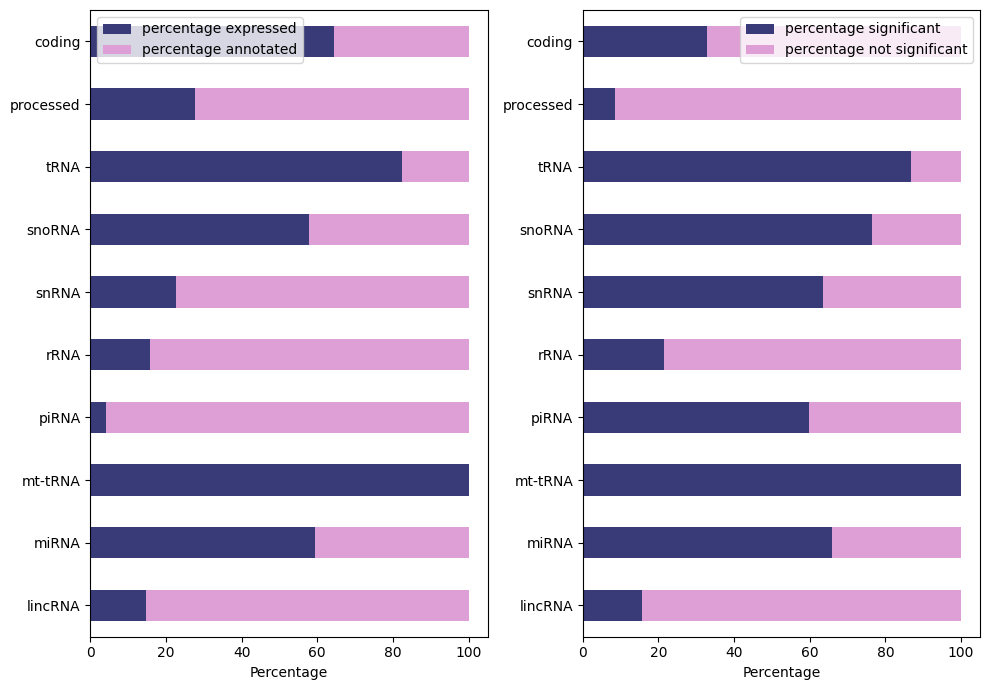

In [30]:
fig,ax = plt.subplots(ncols = 2, figsize = (15,5))
expression_frequency_table.iloc[:,-2:].plot.barh(stacked=True, figsize = (10,7), ax = ax[0], cmap = "tab20b")
expression_frequency.iloc[:,-2:].plot.barh(stacked=True, figsize = (10,7), ax = ax[1], cmap = "tab20b")
ax[0].set_xlabel("Percentage")
ax[1].set_xlabel("Percentage")
plt.tight_layout()
#plt.savefig("ncRNA_expression_percentage.pdf", dpi = 400, bbox_inches = "tight")

In [31]:
# z_score the ncRNA datasets
# z_df_circ = z_score_dataset(circ_data)
z_df_sno = z_score_dataset(sno_data)
z_df_trna = z_score_dataset(trna_data)
z_df_snRNA = z_score_dataset(snRNA_data)
z_df_linc = z_score_dataset(linc_data)
z_df_lnc = z_score_dataset(lnc_data)
z_df_pirna = z_score_dataset(pirna_data)
z_df_rrna = z_score_dataset(rrna_data)
z_df_all = z_score_dataset(all_data)

## Perform hierachical clustering of the different count matrices

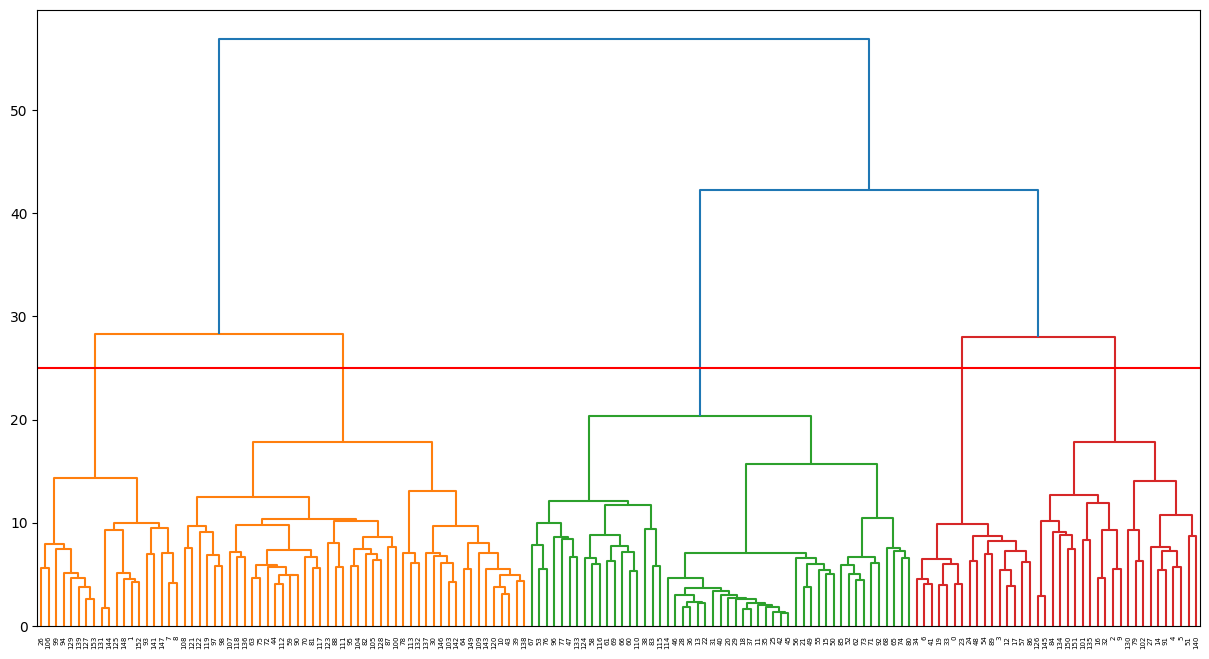

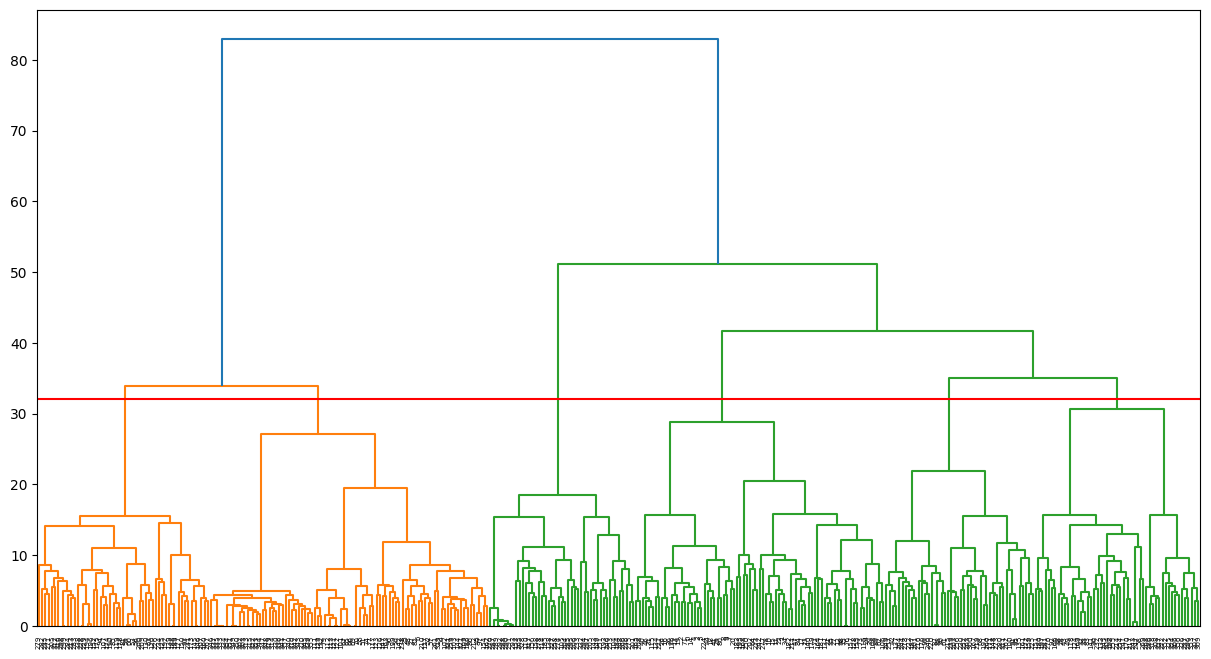

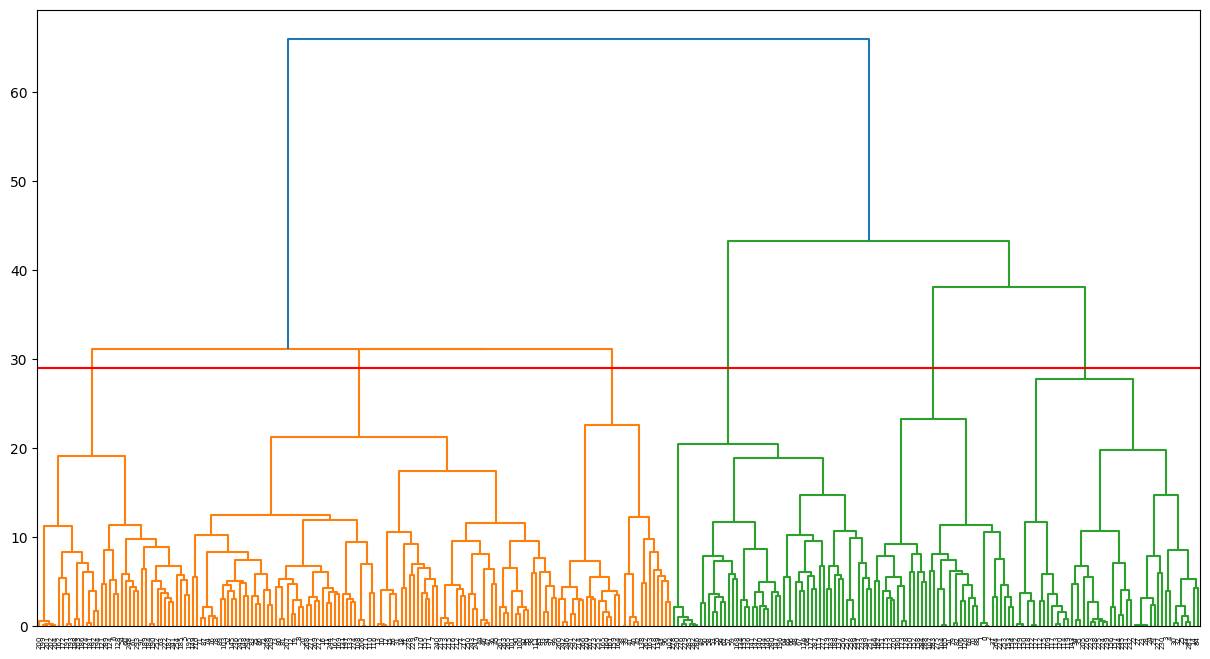

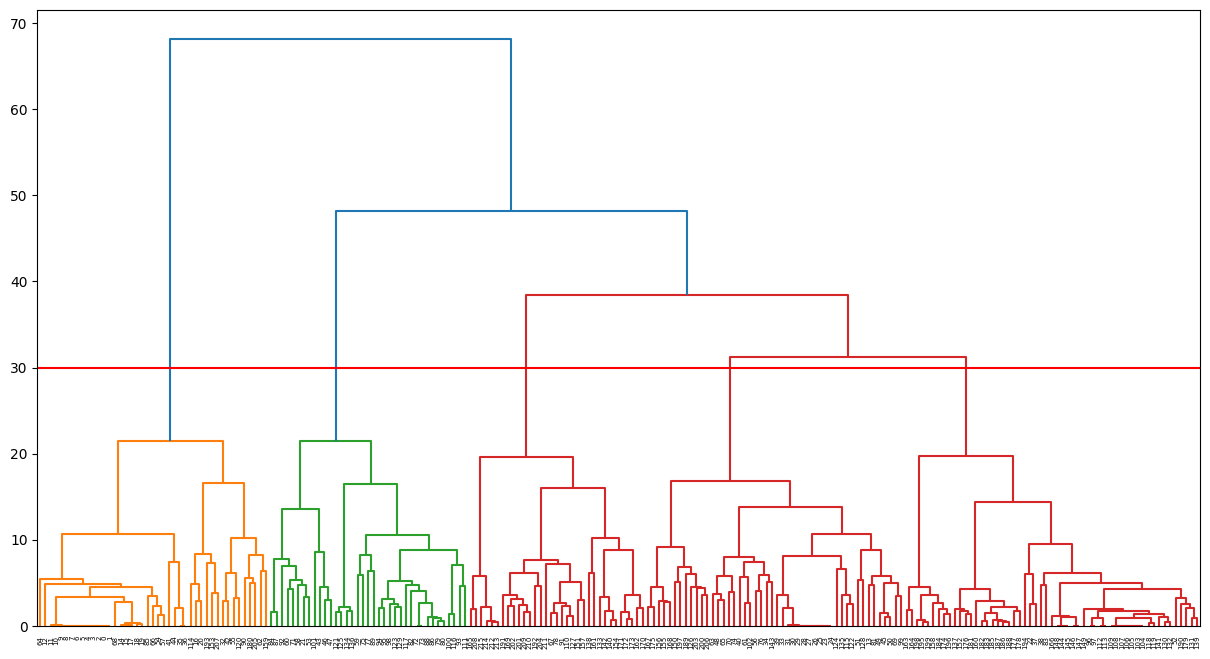

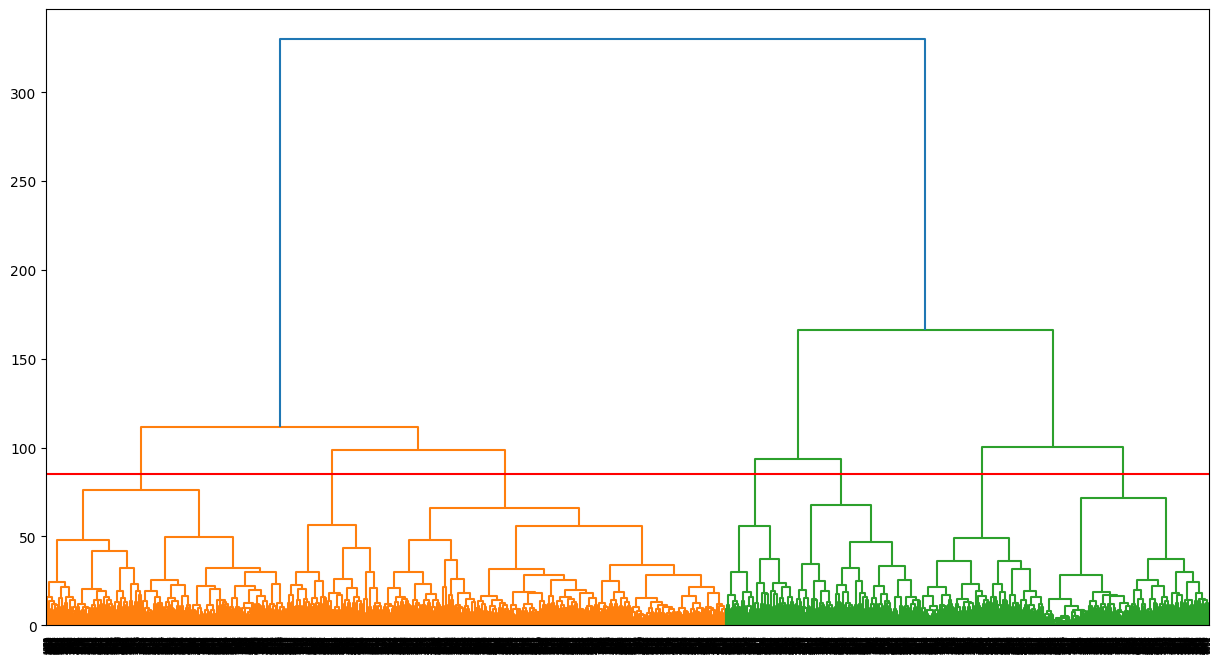

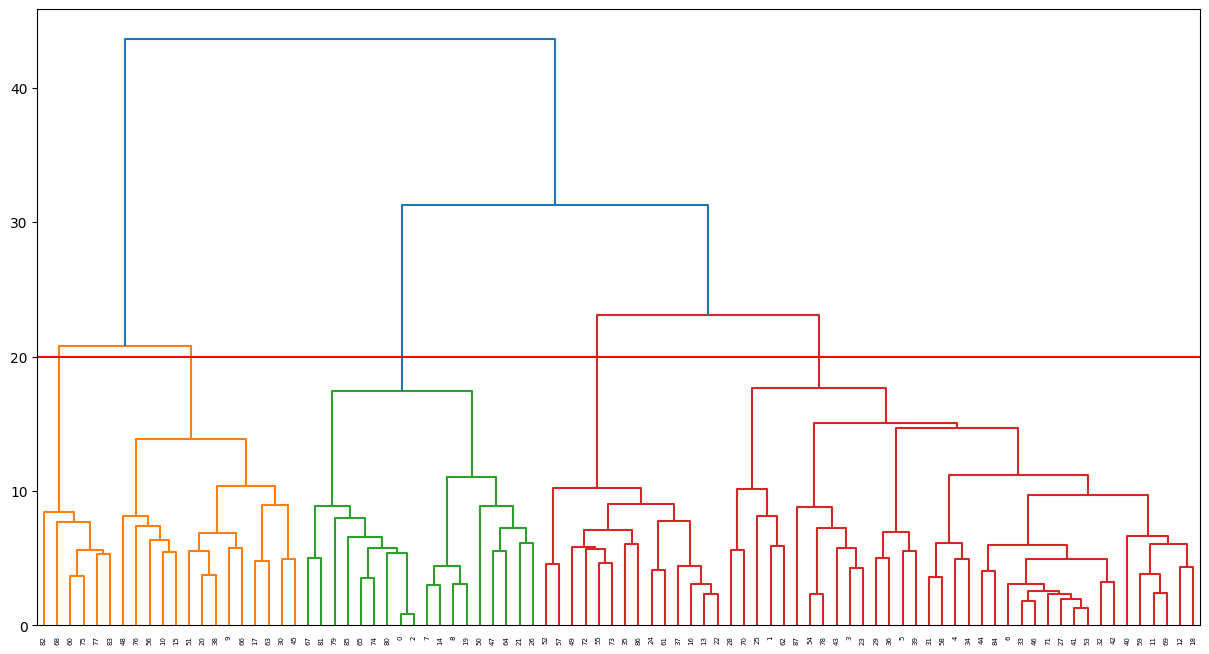

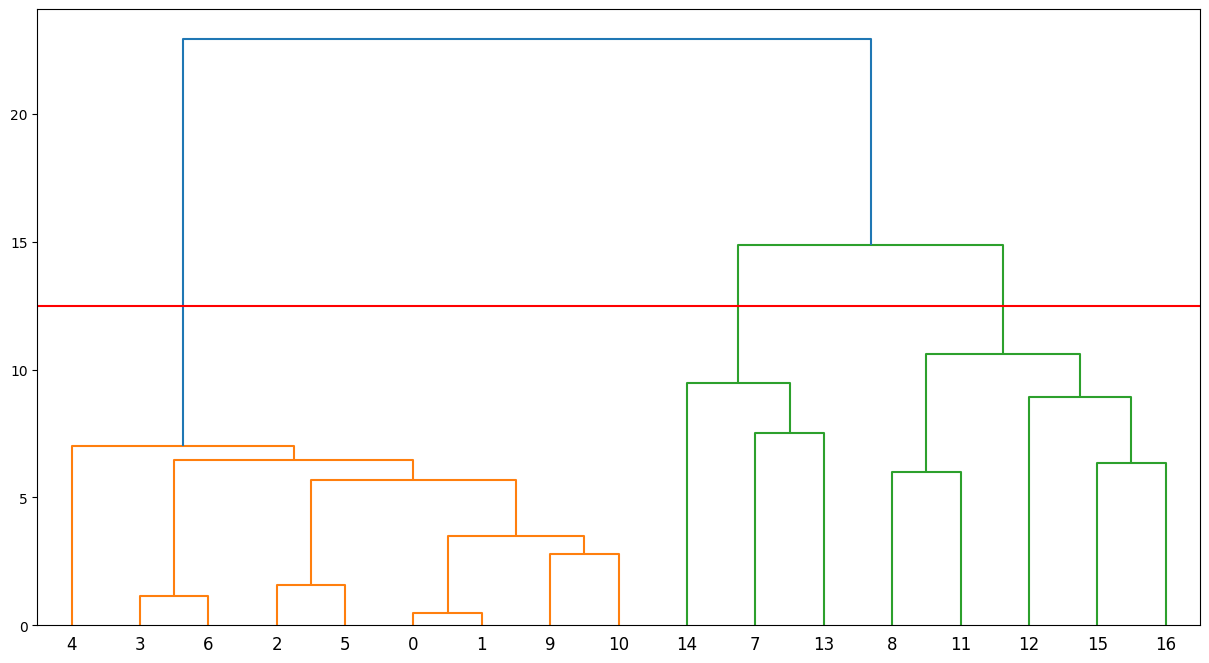

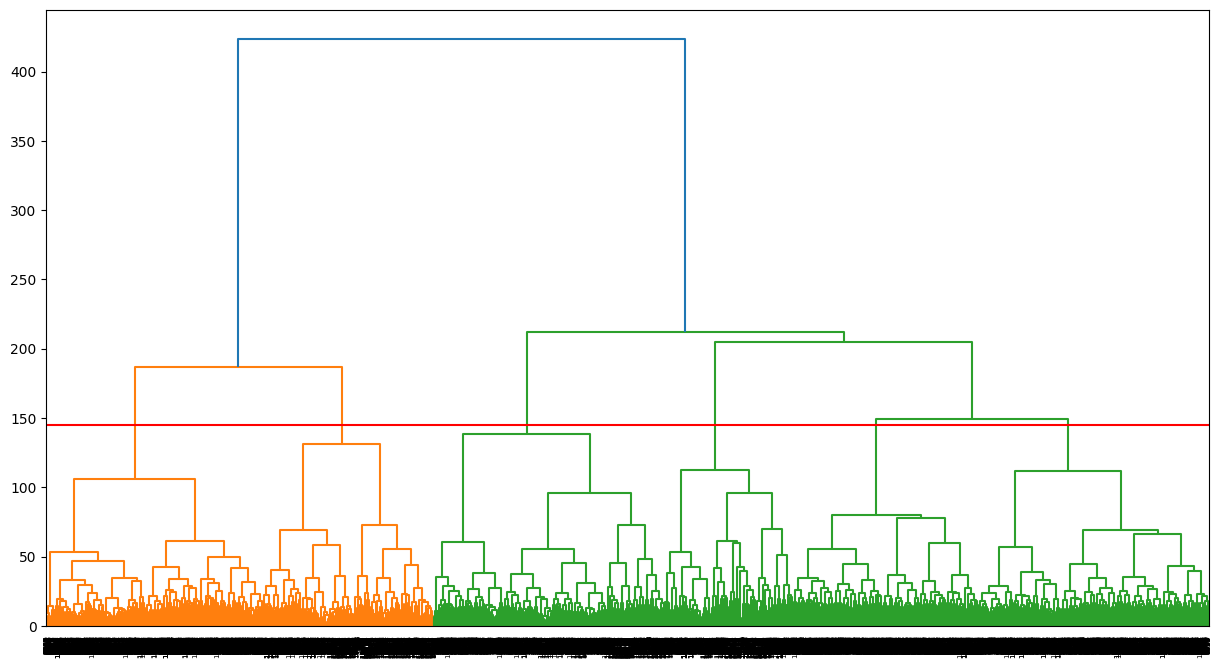

In [32]:
linc_cluster = hierachical_clustering(z_df_linc, 25, "linc_all_cluster_table","linc_cluster_dendogram")
sno_cluster = hierachical_clustering(z_df_sno, 32, "sno_all_cluster_table","sno_cluster_dendogram")
t_cluster = hierachical_clustering(z_df_trna, 29, "sno_all_cluster_table","sno_cluster_dendogram")
sn_cluster =hierachical_clustering(z_df_snRNA, 30, "snRNA_all_cluster_table","snRNA_cluster_dendogram")
lnc_cluster =hierachical_clustering(z_df_lnc, 85, "lncRNA_all_cluster_table","lncRNA_cluster_dendogram")
pirna_cluster =hierachical_clustering(z_df_pirna, 20, "piRNA_all_cluster_table","lpiRNA_cluster_dendogram")
rrna_cluster =hierachical_clustering(z_df_rrna, 12.5, "rrnaRNA_all_cluster_table","rrna_cluster_dendogram")
all_cluster = hierachical_clustering(z_df_all, 145, "all_cluster_table", "all_cluster_dendogram")

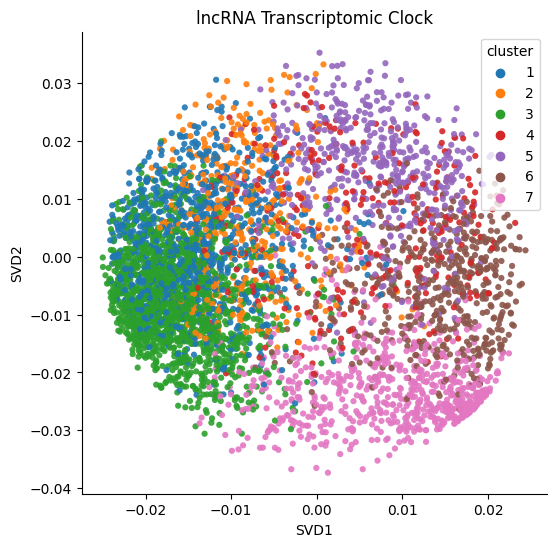

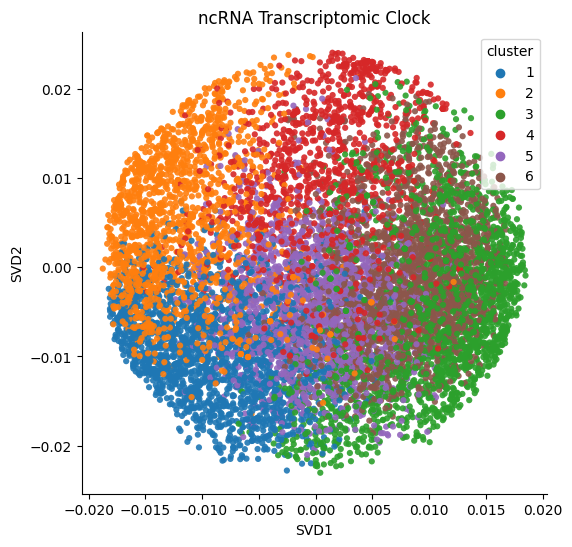

In [35]:
# draws the trancriptomics clocks using singular value decomposition 
svd_scatter(lnc_cluster[0], "lncRNA Transcriptomic Clock")
svd_scatter(all_cluster[0], "ncRNA Transcriptomic Clock")

In [32]:
#label the columns with the same label  so that genes are appropriately order in the figure and can be aggregated based
# on timepoint
columns_liste = [9*[i] for i in ["D0","D5","D9","D16","D26","D36"]] # make appropriate labels
columns_liste = [t for i in columns_liste for t in i] # flatten the list 

In [33]:
# label the columns with the same label for all ncRNA subtypes
# add the cluster
snoRNA_cluster = sno_cluster[0].copy(deep = True)
snoRNA_cluster.columns = columns_liste + ["cluster"]
tRNA_cluster = t_cluster[0].copy(deep = True)
tRNA_cluster.columns = columns_liste + ["cluster"]
snRNA_cluster = sn_cluster[0].copy(deep = True)
snRNA_cluster.columns = columns_liste + ["cluster"]
lincRNA_cluster = linc_cluster[0].copy(deep = True)
lincRNA_cluster.columns = columns_liste + ["cluster"]
lncCluster = lnc_cluster[0].copy(deep = True)
lncCluster.columns = columns_liste + ["cluster"]
rRna_cluster = rrna_cluster[0].copy(deep = True)
rRna_cluster.columns = columns_liste + ["cluster"]
piRNA_cluster = pirna_cluster[0].copy(deep = True)
piRNA_cluster.columns = columns_liste + ["cluster"]
all_clusters = all_cluster[0].copy(deep=True)
all_clusters.columns = columns_liste + ["cluster"]

In [34]:
# use regular expression to substitute numbers 
lincRNA_cluster["name"] = [re.sub("-0[0-9][0-9]", "", i) for i in lincRNA_cluster.index]
#lincRNA_cluster.to_csv("lincRNA_reg_cluster.csv")
#lincRNA_cluster.set_index("name")

In [35]:
# reduce for trajectory analysis
tRNA_cluster_table = tRNA_cluster.iloc[:,-1:]
snoRNA_cluster_table = snoRNA_cluster.iloc[:,-1:]
snRNA_cluster_table = snRNA_cluster.iloc[:,-1:]
lincRNA_cluster_table = lincRNA_cluster.iloc[:,-2:]
lncCluster_table = lncCluster.iloc[:,-1:]
rrna_cluster_table = rRna_cluster.iloc[:,-1:]
pirna_cluster_table = piRNA_cluster.iloc[:,-1:]

In [38]:
lnc_ensembl.rename(columns={'ensembl_gene_id':'Row.names'}, inplace=True)

In [39]:
# merge the tables, the vsd counts as well as the statistics
tRNA_ranked = merge_tables(tRNA_base, tRNA_cluster_table)
snoRNA_ranked= merge_tables(snoRNA_base, snoRNA_cluster_table)
sRNA_ranked = merge_tables(snRNA_base, snRNA_cluster_table)
lincRNA_ranked = merge_tables(linc_base, lincRNA_cluster_table)
lncRNA_ranked = merge_tables(lnc_ensembl, lncCluster_table)
rrna_ranked = merge_tables(rrna_base, rrna_cluster_table)
pirna_ranked = merge_tables(pirna_base, pirna_cluster_table)
pirna_ranked["Row.names"] = [i.split("|")[0] for i in pirna_ranked["Row.names"].tolist()]
z_df_pirna.index = [i.split("|")[0] for i in z_df_pirna.index]

# Retrieve the most significant genes and trajectories per cluster

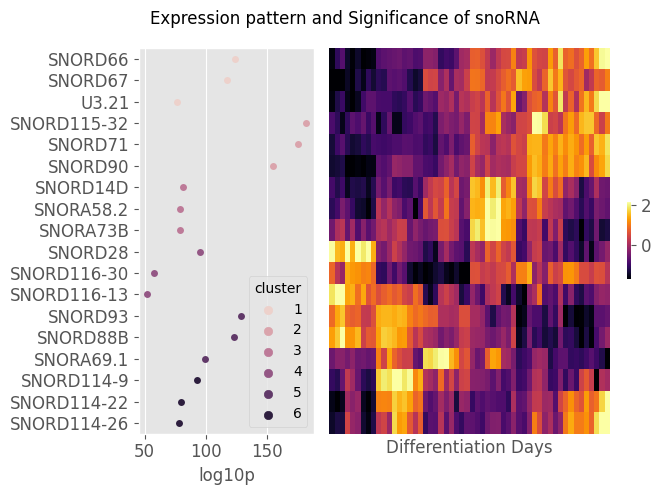

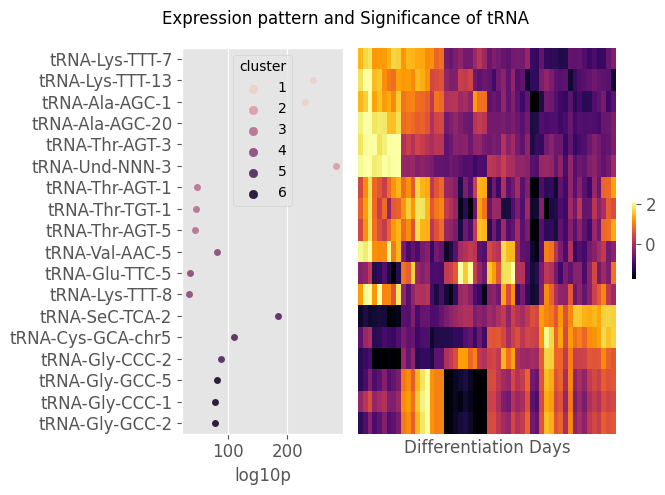

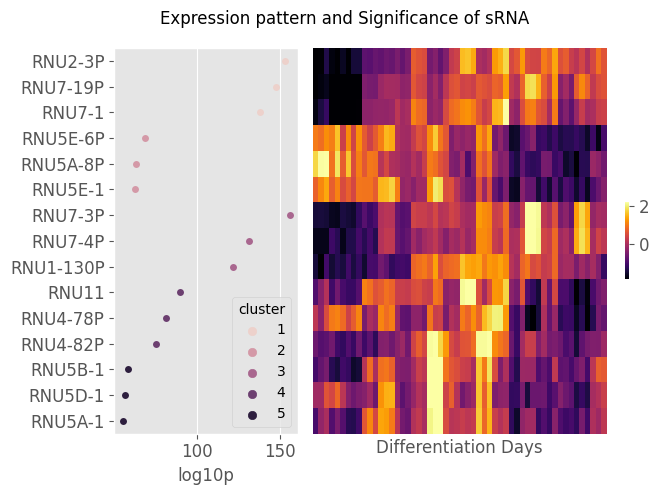

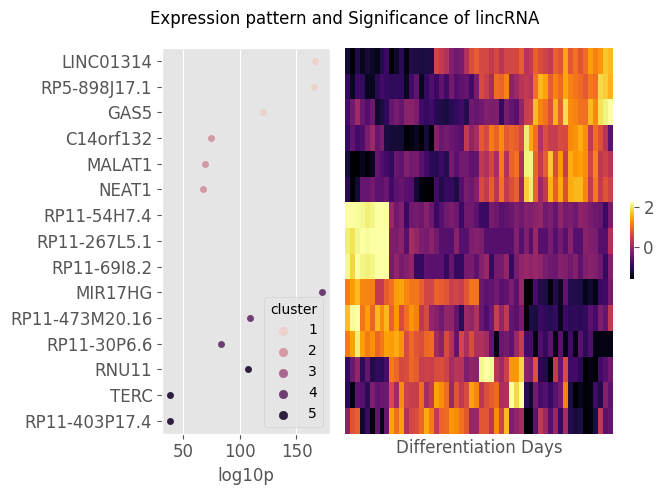

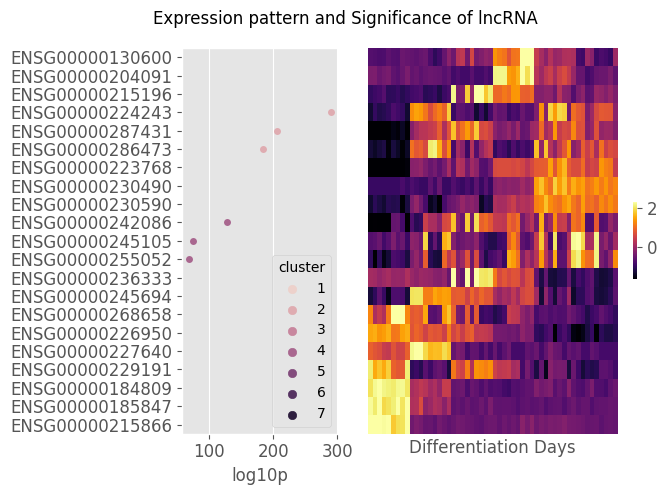

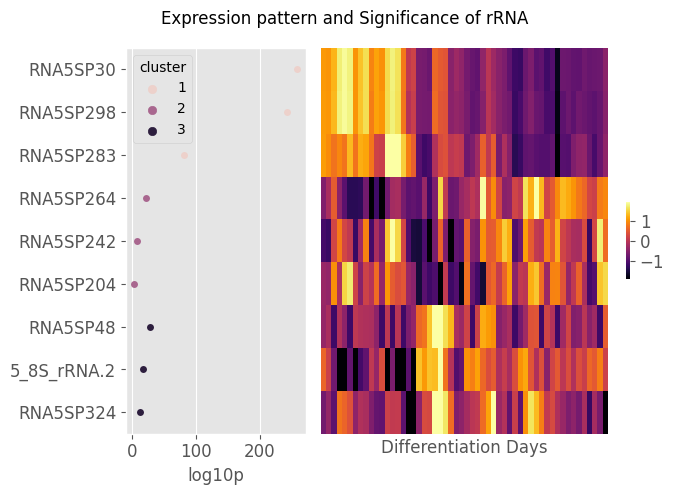

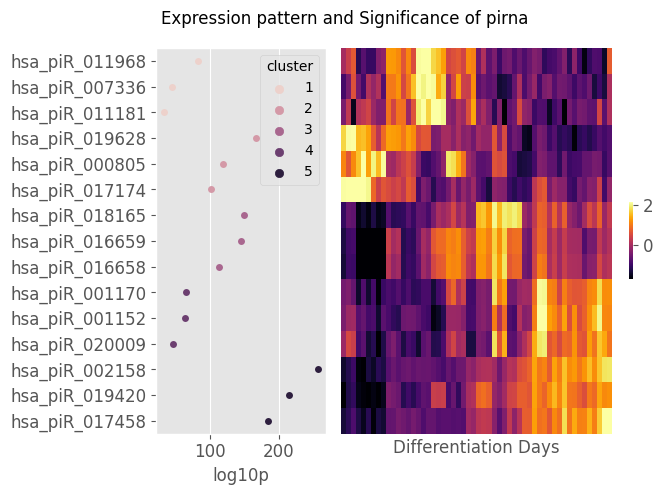

In [40]:
# initialize the drawing
get_highest_ranked(snoRNA_ranked, z_df_sno, n_largest = 3, title = "snoRNA")
get_highest_ranked(tRNA_ranked, z_df_trna, n_largest = 3, title = "tRNA")
get_highest_ranked(sRNA_ranked, z_df_snRNA, n_largest = 3, title = "sRNA")
get_highest_ranked(lincRNA_ranked, z_df_linc, n_largest = 3, title = "lincRNA")
get_highest_ranked(lncRNA_ranked, z_df_lnc, n_largest = 3, title = "lncRNA")
get_highest_ranked(rrna_ranked, z_df_rrna, n_largest = 3, title = "rRNA")
get_highest_ranked(pirna_ranked, z_df_pirna, n_largest = 3, title = "pirna")

In [41]:
# Groupby the ncRNAs per cluster and calculates the mean per cluster
grouped_tRNA = tRNA_cluster.groupby("cluster").agg("mean")
grouped_sno = snoRNA_cluster.groupby("cluster").agg("mean")
grouped_sn = snRNA_cluster.groupby("cluster").agg("mean")
grouped_linc = lincRNA_cluster.groupby("cluster").agg("mean")
grouped_lnc = lncCluster.groupby("cluster").agg("mean")
grouped_rRNA = rRna_cluster.groupby("cluster").agg("mean")
grouped_pirna = piRNA_cluster.groupby("cluster").agg("mean")
grouped_all = all_clusters.groupby("cluster").agg("mean")

Text(0, 0.5, 'Aggregated z-score')

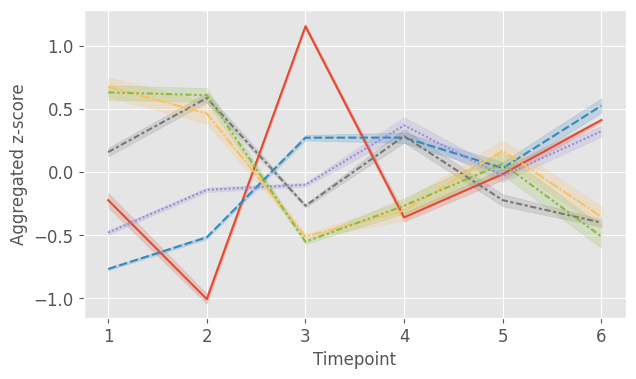

In [43]:
#basic trajectories for al ncRNAs
grouped_all.head()
fig,ax = plt.subplots(figsize = (7,4))
sns.lineplot(data = grouped_all, legend = False)
plt.xlabel("Timepoint")
plt.ylabel("Aggregated z-score")

draws the figure
draws the figure
draws the figure
draws the figure
draws the figure
draws the figure
draws the figure
draws the figure


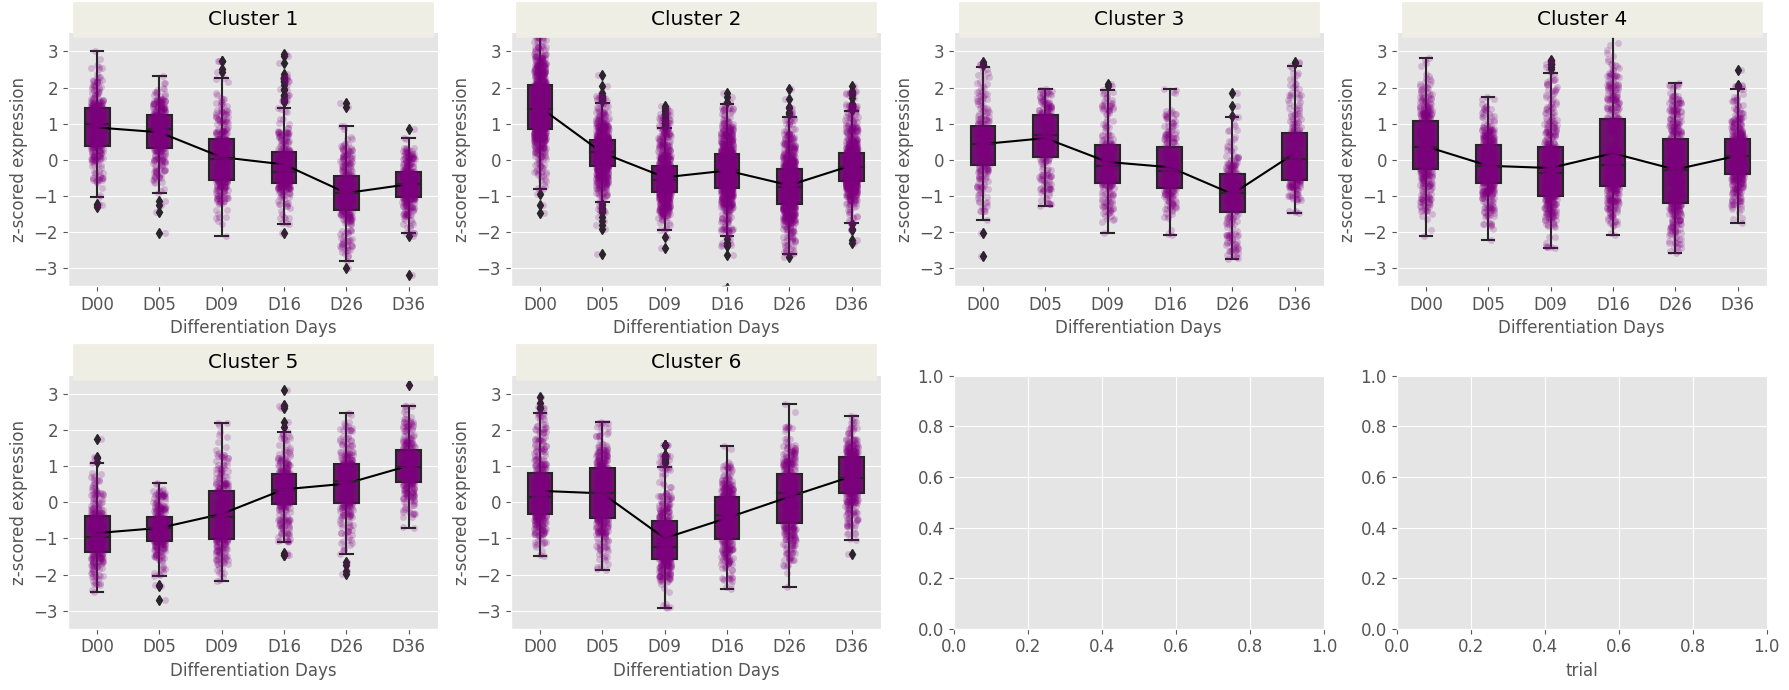

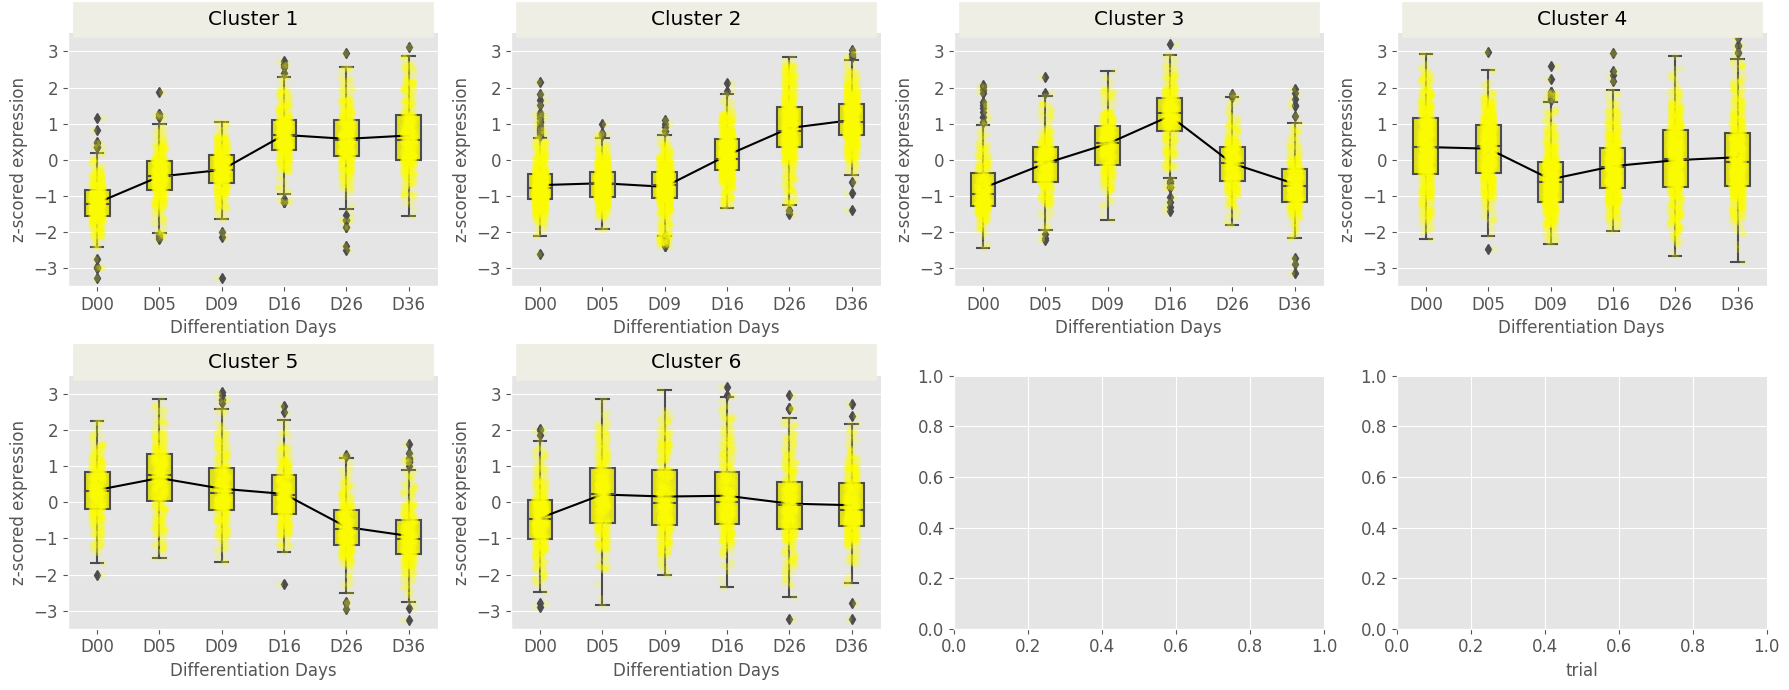

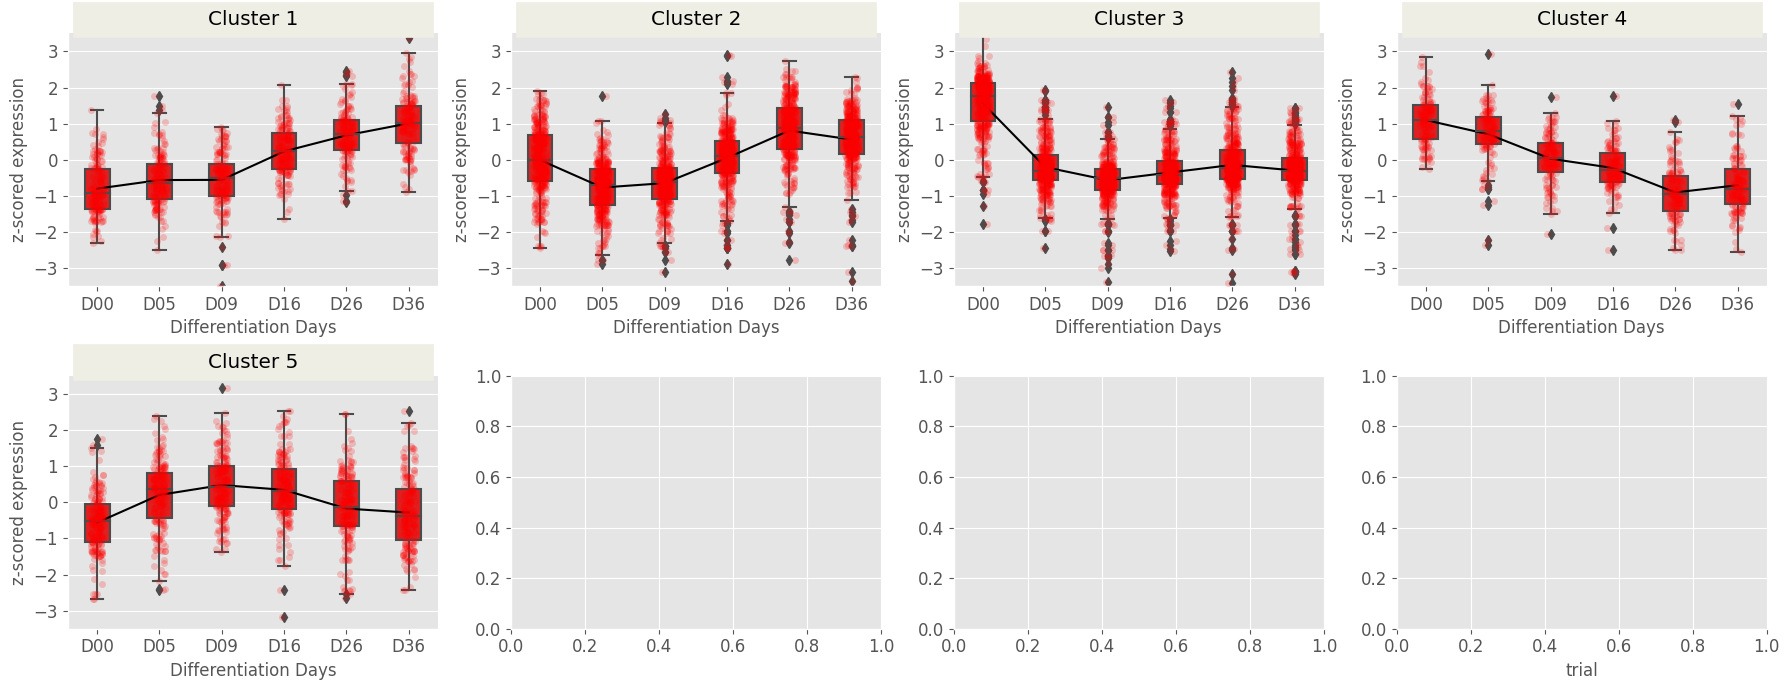

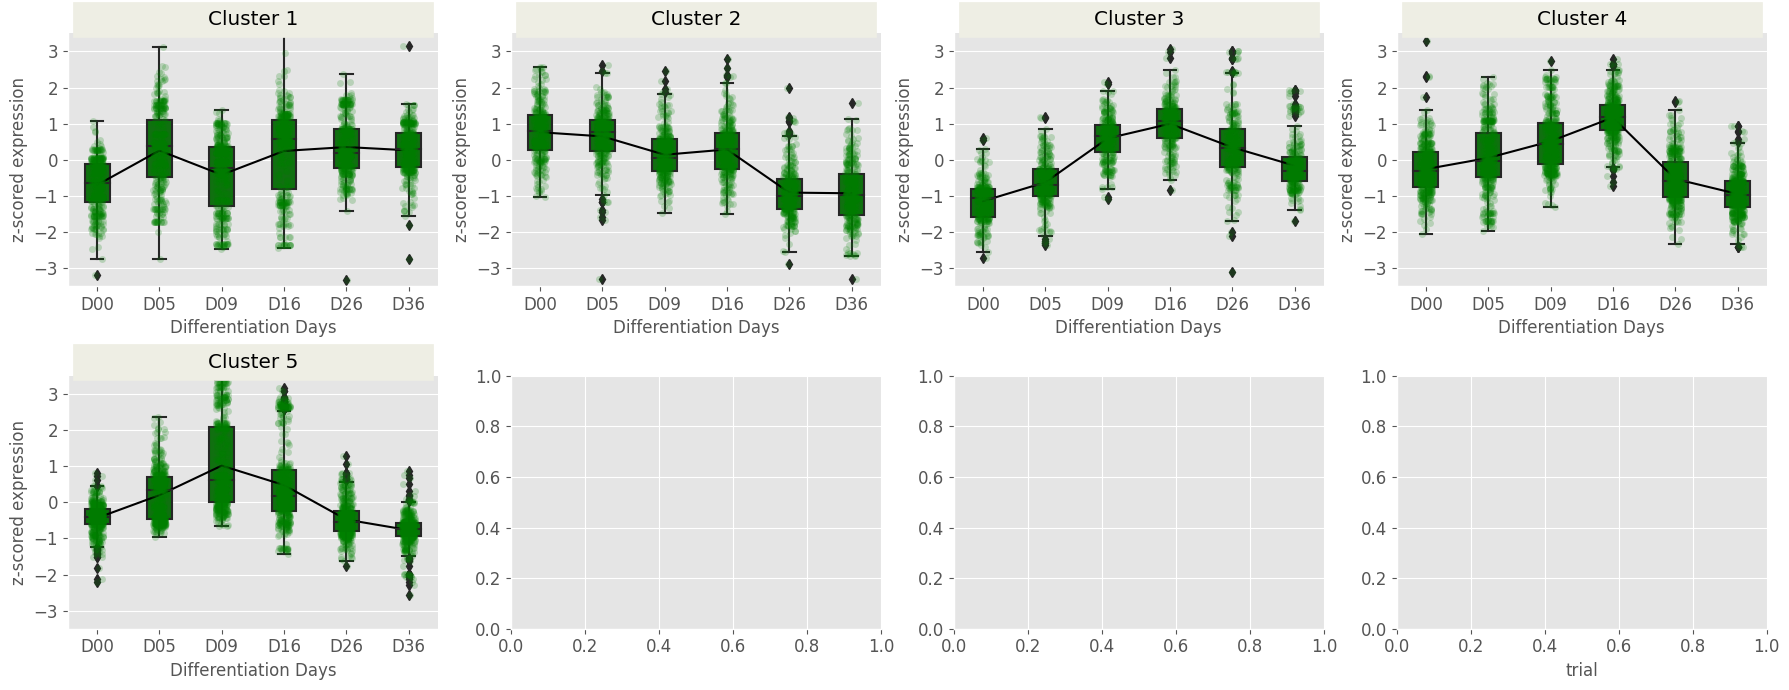

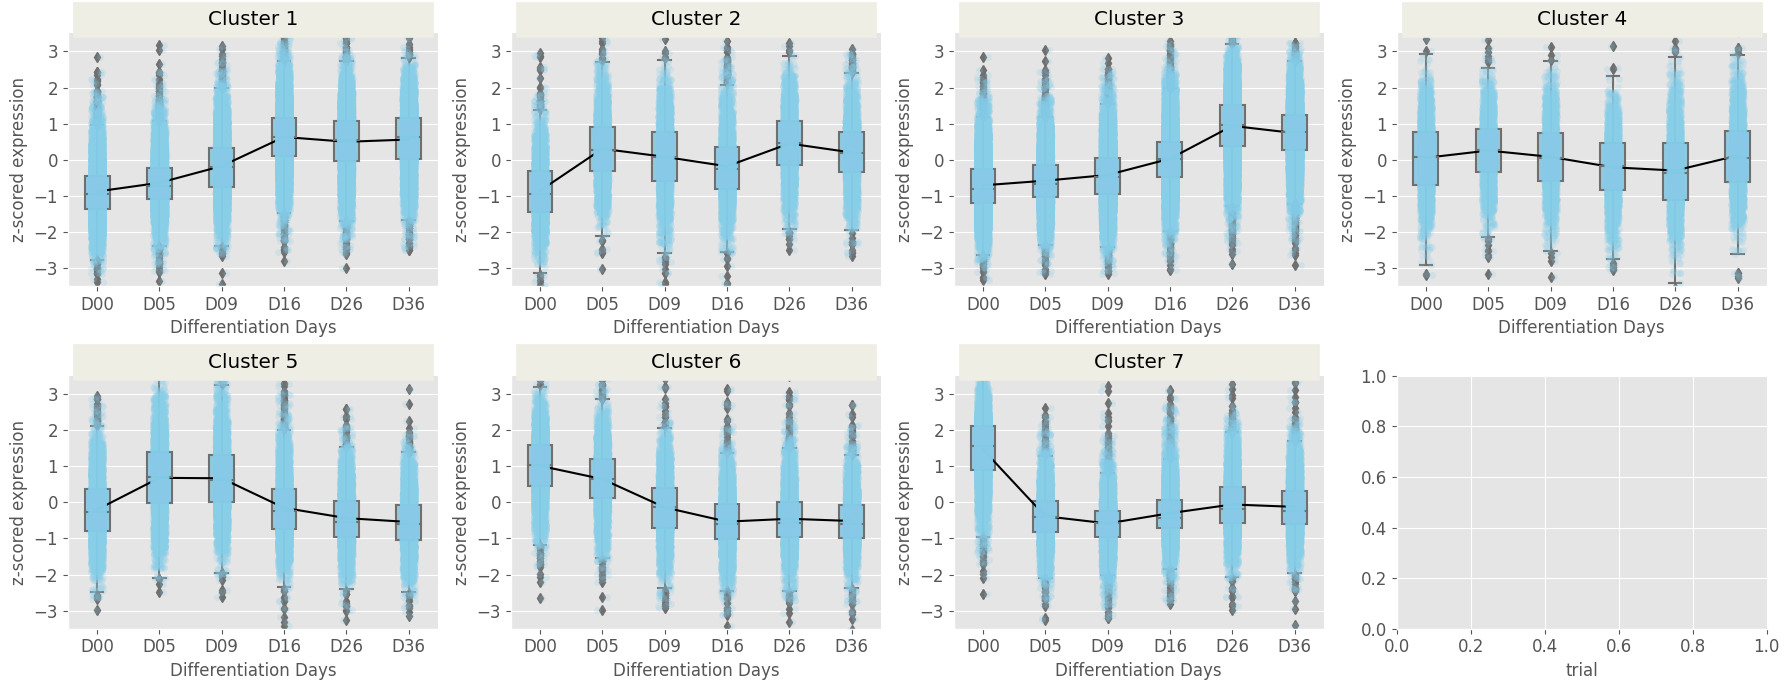

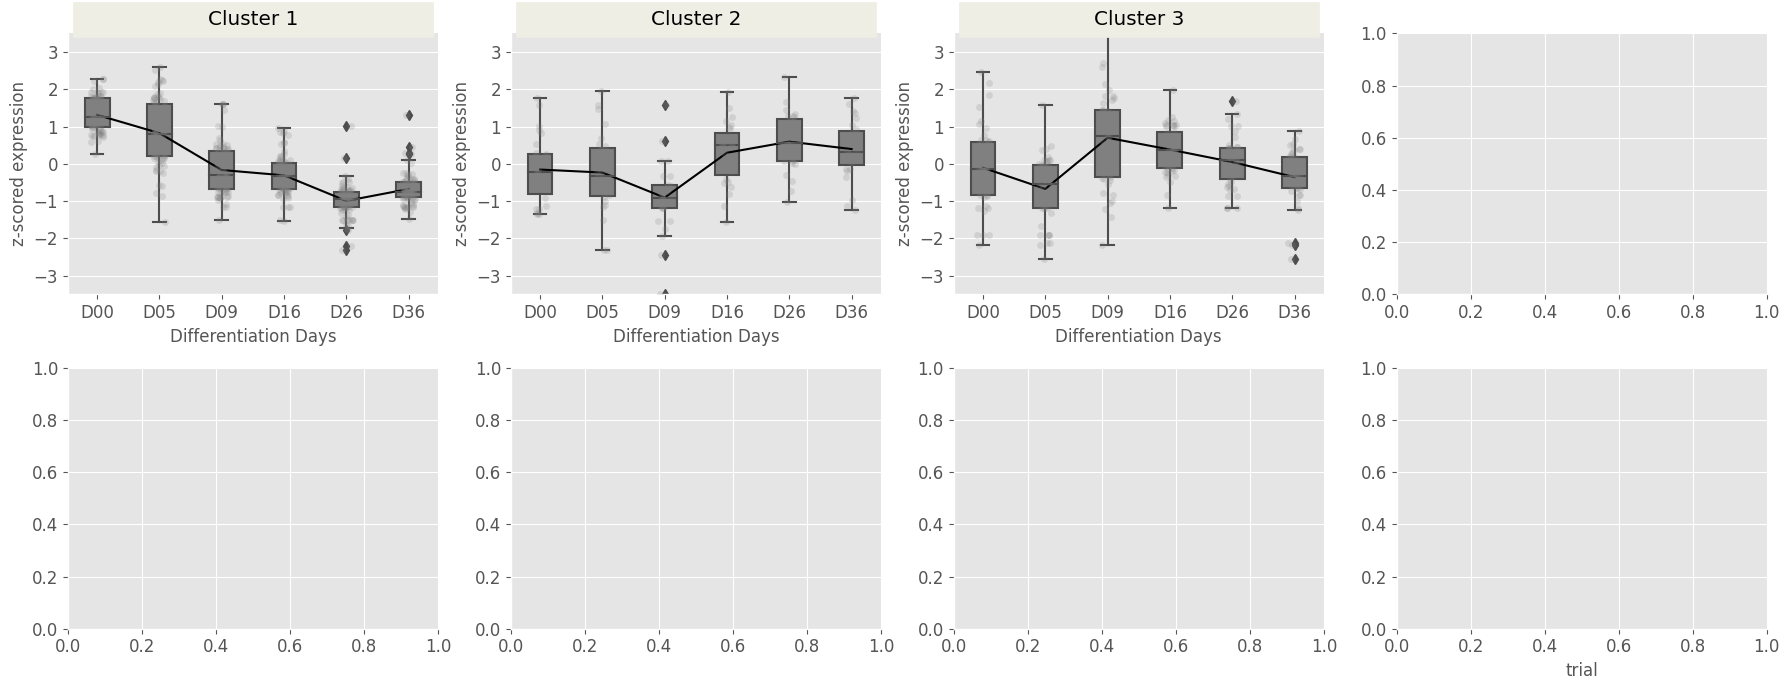

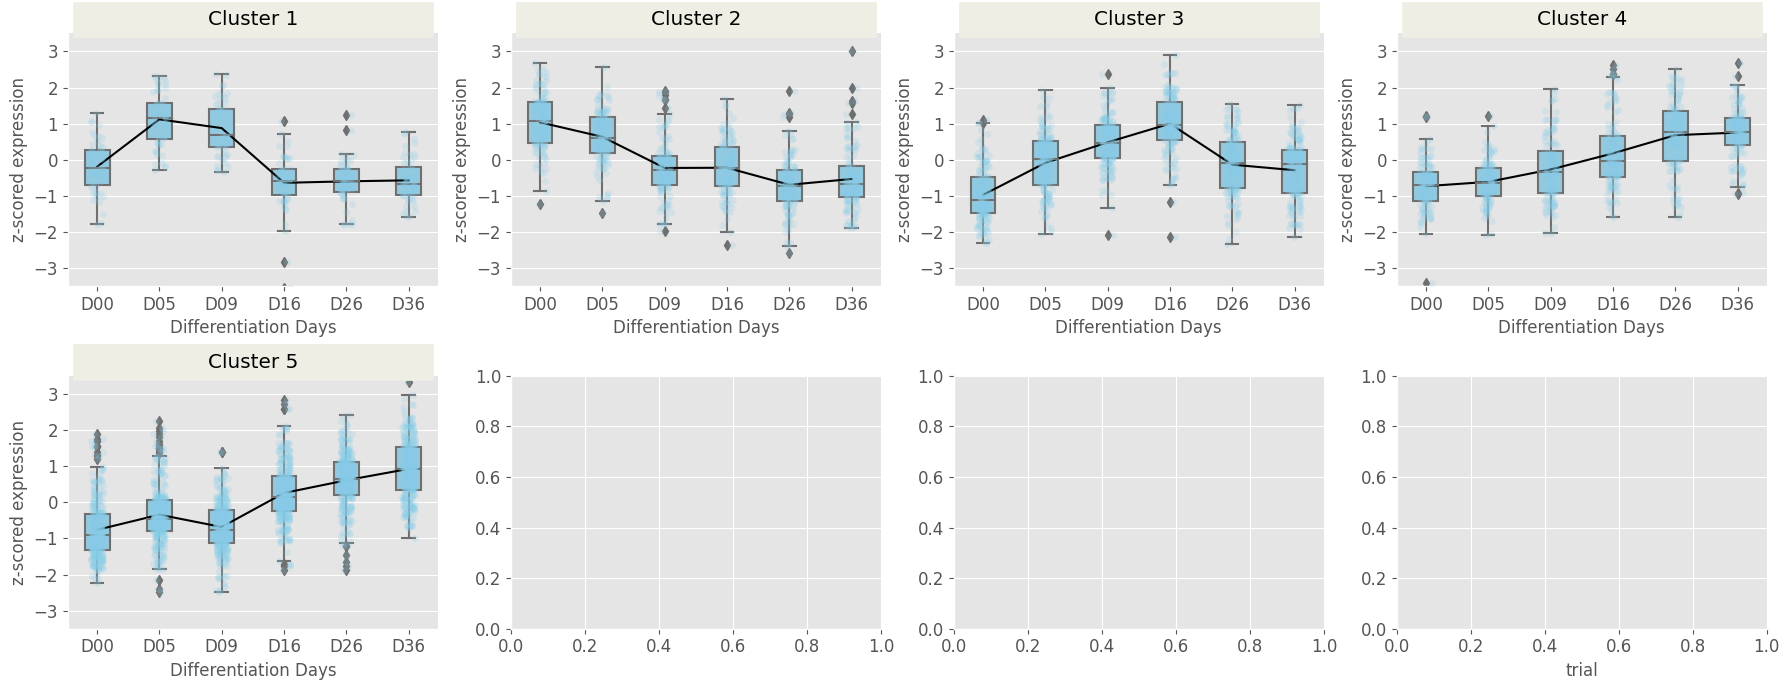

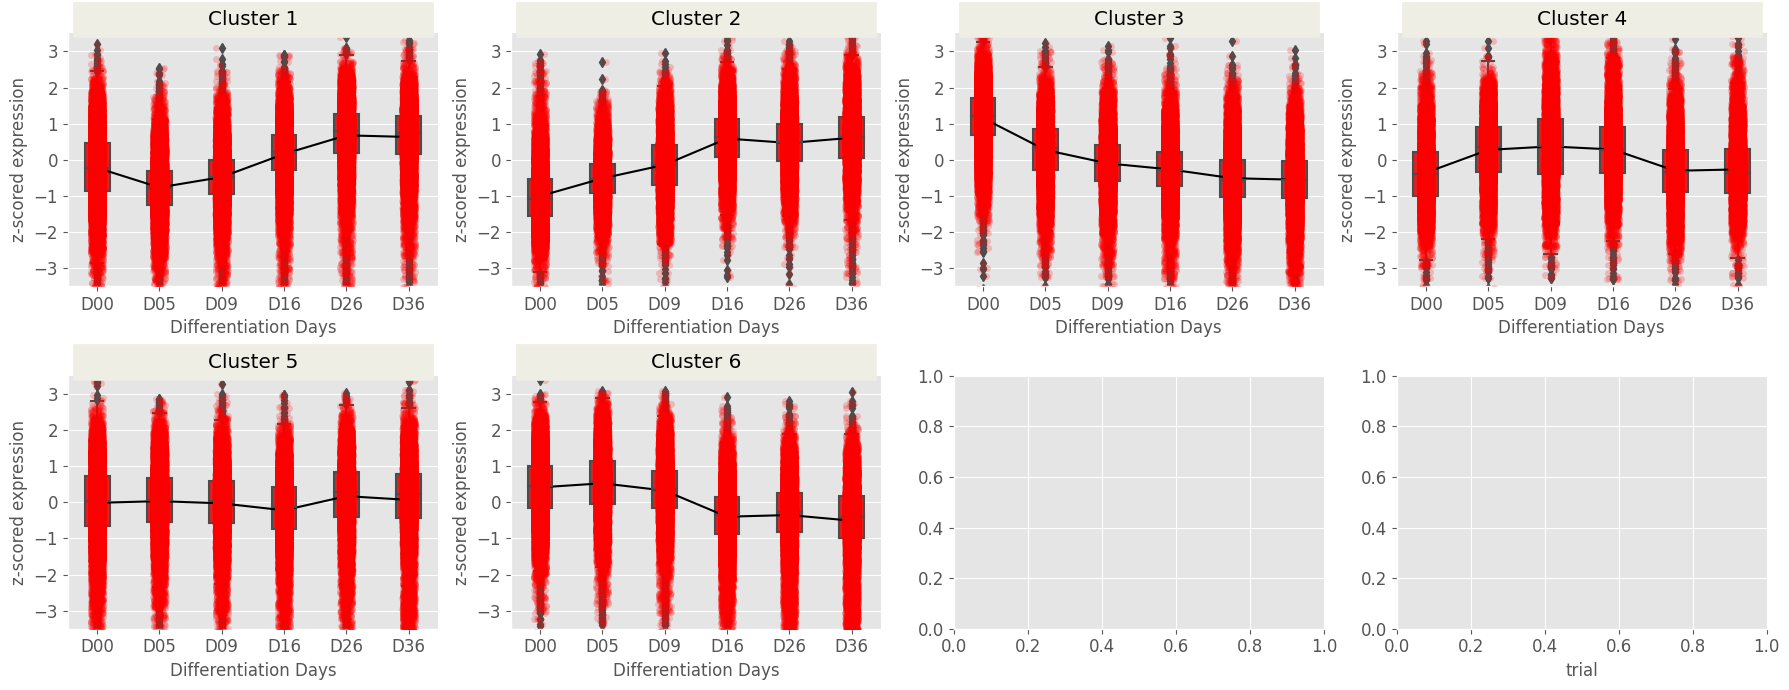

In [44]:
# draw the corresponding trajectories
trajectories_drawing(tRNA_cluster, grouped_tRNA, "tRNA","purple", True)
trajectories_drawing(snoRNA_cluster, grouped_sno, "snoRNA", "yellow",True)
trajectories_drawing(lincRNA_cluster.iloc[:,:-1], grouped_linc, "lincRNA", "red", True)
trajectories_drawing(snRNA_cluster, grouped_sn, "snRNA", "green", True)
trajectories_drawing(lncCluster, grouped_lnc, "lncRNA", "skyblue", True)
trajectories_drawing(rRna_cluster, grouped_rRNA, "rRNA", "grey", True)
trajectories_drawing(piRNA_cluster, grouped_pirna, "piRNA", "skyblue", True)
trajectories_drawing(all_clusters, grouped_all, "all", "red", True)

# snoRNA Analysis

In [45]:
# Retrieve the host-gene information and the box informatin 
snodb_selected = snodb[["Symbol","Box","Host Symbol"]]
snodb_selected = snodb_selected.drop_duplicates()
snodb_selected.set_index("Symbol", inplace = True)

In [47]:
# load the gene expression dataset for hsot-gene expression analysis 
mrna_data  = pd.read_csv("../files/lcnRNA_iPSC-vsd_with_symbols.csv")
mrna_data_expression = mrna_data.dropna().set_index("external_gene_name").iloc[:,2:-1]
mrna_data_expression.head()

19101-0001  19101-0002  19101-0003  19101-0019  \
external_gene_name                                                   
TSPAN6               10.712047   10.775174   10.826645   10.604831   
TNMD                  7.127091    7.256732    7.316036    7.147523   
DPM1                  9.913351   10.002120   10.049799    9.841315   
SCYL3                 8.804597    8.616728    8.834516    8.682841   
C1orf112              9.926558    9.848768   10.003379    9.921121   

                    19101-0020  19101-0021  19101-0037  19101-0038  \
external_gene_name                                                   
TSPAN6               10.806599   10.676097   10.622711   10.729344   
TNMD                  7.144077    7.359560    6.935473    6.965932   
DPM1                 10.010911    9.910549    9.797140    9.877934   
SCYL3                 8.433321    8.461775    8.562371    8.722602   
C1orf112             10.033166    9.786939    9.556385    9.555379   

                    19101-0039  19101-0004  ...  19101-0051  19101-0016  \
external_gene_name                          ...                           
TSPAN6               10.566953   11.435698  ...   10.779026   10.556508   
TNMD                  6.908312    6.753988  ...    6.564103    6.689541   
DPM1                  9.770370    9.915456  ...    9.205629    9.180408   
SCYL3                 8.606861    9.135457  ...    8.841066    8.723755   
C1orf112              9.562343    9.852004  ...    8.819631    8.112140   

                    19101-0017  19101-0018  19101-0034  19101-0035  \
external_gene_name                                                   
TSPAN6               10.516710   10.494209   10.284449   10.333430   
TNMD                  6.564103    6.861184    6.564103    6.564103   
DPM1                  9.265761    9.301260    9.166103    9.250860   
SCYL3                 8.732794    8.703591    8.577205    8.534458   
C1orf112              8.359879    8.266129    8.051419    8.006860   

                    19101-0036  19101-0052  19101-0053  19101-0054  
external_gene_name                                                  
TSPAN6               10.348392   10.784774   10.529253   10.500530  
TNMD                  6.564103    6.688927    6.564103    6.564103  
DPM1                  9.220334    9.052606    9.063885    9.208031  
SCYL3                 8.643686    8.858309    8.720391    8.659819  
C1orf112              8.000971    8.302909    8.517924    8.265168  

[5 rows x 54 columns]

In [48]:
# set the colnames accordingly and get the expression
colnames_mrna = [[i]* 9 for i in ["DAY00", "DAY05", "DAY09", "DAY16", "DAY26", "DAY36"]] 
colnames_mrna = [t for i in colnames_mrna for t in i]
z_df_mrna = z_score_dataset_mrna(mrna_data_expression, colnames_mrna)
z_df_mrna.head()

DAY00     DAY00     DAY00     DAY00     DAY00     DAY00  \
TSPAN6   -0.118754  0.021188  0.135290 -0.356434  0.090853 -0.198450   
TNMD      1.968243  2.567271  2.841295  2.062653  2.046727  3.042404   
DPM1      1.181191  1.488181  1.653067  0.932070  1.518582  1.171503   
SCYL3     0.068270 -1.011389  0.240213 -0.631444 -2.065408 -1.901888   
C1orf112  1.148310  1.024812  1.270269  1.139679  1.317559  0.926654   

             DAY00     DAY00     DAY00     DAY05  ...     DAY26     DAY36  \
TSPAN6   -0.316798 -0.080409 -0.440403  1.485460  ...  0.029728 -0.463557   
TNMD      1.082835  1.223579  0.957331  0.244250  ... -0.633145 -0.053539   
DPM1      0.779302  1.058710  0.686723  1.188473  ... -1.266313 -1.353535   
SCYL3    -1.323775 -0.402947 -1.068092  1.969684  ...  0.277857 -0.396320   
C1orf112  0.560633  0.559035  0.570091  1.029950  ... -0.609022 -1.732218   

             DAY36     DAY36     DAY36     DAY36     DAY36     DAY36  \
TSPAN6   -0.551784 -0.601664 -1.066666 -0.958085 -0.924917  0.042470   
TNMD     -0.633145  0.739569 -0.633145 -0.633145 -0.633145 -0.056375   
DPM1     -1.058359 -0.935592 -1.403006 -1.109890 -1.215458 -1.795510   
SCYL3    -0.344374 -0.512198 -1.238523 -1.484183 -0.856463  0.376950   
C1orf112 -1.338912 -1.487749 -1.828617 -1.899358 -1.908706 -1.429357   

             DAY36     DAY36  
TSPAN6   -0.523979 -0.587651  
TNMD     -0.633145 -0.633145  
DPM1     -1.756505 -1.258007  
SCYL3    -0.415649 -0.763750  
C1orf112 -1.088005 -1.489274  

[5 rows x 54 columns]

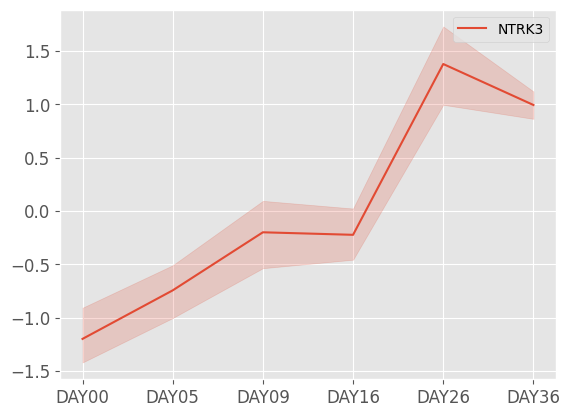

In [49]:
# check expression data if comparable to the expression data found in nociceptra
check_expression(z_df_mrna, ["NTRK3"], "plot")

In [51]:
snoRNA_cluster_table.info()

<class 'pandas.core.frame.DataFrame'>
Index: 358 entries, SNORD30 to SNORD115-2
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   cluster  358 non-null    int32
dtypes: int32(1)
memory usage: 4.2+ KB


In [52]:
# remove to the 201 since it is not assigned in the database
snoRNA_cluster_table.index = [i.split(":")[0] for i in snoRNA_cluster_table.index]

In [53]:
# get the z_df counts
snoRNA_z_counts = z_df_sno.copy(deep = True)
snoRNA_z_counts.index = [i.split(":")[0] for i in snoRNA_z_counts.index]

Start correlation calculation
There was an error; Gene not found: 'C6orf48'
There was an error; Gene not found: 'LINC02001'
There was an error; Gene not found: 'C6orf48'
There was an error; Gene not found: 'AC012501.2'
There was an error; Gene not found: 'IARS'
There was an error; Gene not found: 'RP11-941H19.3'
There was an error; Gene not found: 'UBA6-AS1'
There was an error; Gene not found: 'RP11-160E2.6'
There was an error; Gene not found: 'RP11-20I20.2'
There was an error; Gene not found: 'RP11-82O19.1'
There was an error; Gene not found: 'CTD-2555K7.2'
There was an error; Gene not found: 'CTD-2651B20.8'
There was an error; Gene not found: 'RP11-357K6.3'
There was an error; Gene not found: 'RP11-114M1.2'
There was an error; Gene not found: 'TMEM161B-AS1'
There was an error; Gene not found: 'KCNE1B'
There was an error; Gene not found: 'RP11-296E23.1'
There was an error; Gene not found: 'RP11-74M13.4'
There was an error; Gene not found: 'RP11-176N18.2'
There was an error; Gene not f

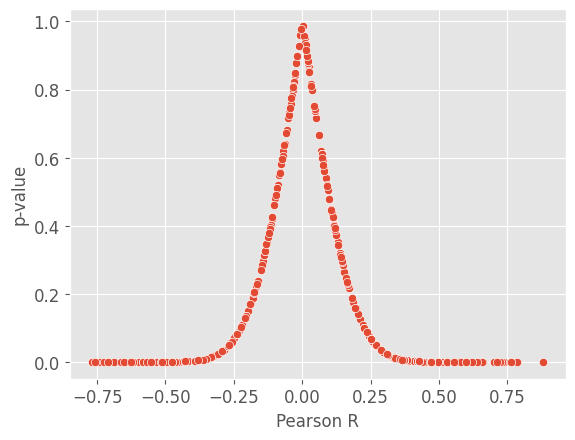

In [56]:
snodb_host = snodb_selected["Host Symbol"].dropna()
differential_expressed_sno  = snodb_host[snodb_host.index.isin(snoRNA_z_counts.index)]

def get_host_genes(mrna:pd.DataFrame, sno_vsd:pd.DataFrame, sno_db: pd.DataFrame):
    """ this runs correlation analysis for all snoRNAs and the snoRNA host-genes"""
    fig, ax = plt.subplots()
    # make a dictionary hodling the correlation
    correlated_genes = {"positive_gene" : [], "positive_sno" : [], "negative_gene" : [], "negative_sno": []}
    corr = []
    p_value = []
    
    print("Start correlation calculation")
    for i,t in zip(sno_db.index, sno_db):
        try:
            host_gene = mrna[mrna.index.isin([t])].T[t].tolist()
            sno_rna = sno_vsd[sno_vsd.index.isin([i])].T[i].tolist()
        except Exception as e:
            print(f"There was an error; Gene not found: {e}")
            
        if len(host_gene) > 0 and len(sno_rna) > 0:
            try: 
                correlation = stats.pearsonr(host_gene, sno_rna)
                corr.append(correlation[1])
                p_value.append(correlation[0])
                #
                if correlation[0] > 0.4:
                    correlated_genes["positive_gene"].append(t)
                    correlated_genes["positive_sno"].append(i)
                elif correlation[0] < -0.4:
                    correlated_genes["negative_gene"].append(t)
                    correlated_genes["negative_sno"].append(i)
                    
            except Exception as e:
                print(f"gene expression contains NAN {e}")
    print("drawing figure")
    sns.scatterplot(y = corr, x = p_value)
    plt.xlabel("Pearson R")
    plt.ylabel("p-value")
    plt.savefig("snoRNA_correlation_plot.pdf", dpi = 300, bbox_inches = "tight")
    
    return correlated_genes
                
correlated_genes = get_host_genes(z_df_mrna, snoRNA_z_counts, differential_expressed_sno)

In [60]:
enrichment(correlated_genes["positive_gene"], "hsapiens", "positive_correlated_sno_genes")
enrichment(correlated_genes["negative_gene"], "hsapiens", "negative_correlated_sno_genes")

['CSKMT', 'SNHG14', 'RPL39', 'TAF1D', 'NOP56', 'RPLP2', 'SNHG3', 'TAF1D', 'SNHG14', 'MAGED4', 'MAGED4B', 'RPL5', 'C19orf48', 'NOP58', 'RP11-20I20.2', 'RP11-82O19.1', 'PCNA', 'ATP6V0E1', 'SNHG14', 'DANCR', 'TAF1D', 'TAF1D', 'SNHG11', 'SNHG14', 'MAGED2', 'NOP53', 'SNHG12', 'SF3B3', 'TMEM161B-AS1', 'TRO', 'SNHG12', 'ERVMER34-1', 'USP49', 'DIPK1A', 'ZMYM4', 'PSD3', 'KCNE1B', 'RP11-296E23.1', 'SNHG26', 'RP11-74M13.4', 'SNHG14', 'SNHG4', 'SNHG18', 'ZBED3', 'RPL4', 'RPS8', 'CTD-2298J14.2', 'CNTNAP4', 'RPL4', 'SNHG14', 'SNHG14', 'SNHG14', 'RPSA', 'ALPK3', 'RP4-601P9.2', 'RP11-22B23.1', 'SNHG1', 'CCNB1IP1']
['SNHG14', 'CNOT1', 'SNHG14', 'SNHG14', 'SNHG14', 'SNHG14', 'SNHG14', 'SNHG14', 'SNHG14', 'RPL23A', 'SNHG14', 'SNHG14', 'DDX39B', 'SNHG14', 'DDX39B', 'RBMX', 'SNHG14', 'SNHG14', 'SNHG14', 'SNHG14', 'SNHG14', 'SNHG14', 'SNHG14', 'NAP1L4', 'SNHG14', 'NOP56', 'EIF4A1', 'SNHG14', 'PPAN', 'RPL23A', 'ATP5F1B', 'SNHG14', 'NCL', 'SNHG14', 'SNHG14', 'TCP1', 'PTCD3', 'SNHG14', 'LINC02001', 'TOMM20', '

go-terms                                        description source  \
0   GO:0005730                                          nucleolus  GO:CC   
1   GO:0044391                                  ribosomal subunit  GO:CC   
2   GO:0016281  eukaryotic translation initiation factor 4F co...  GO:CC   
3   GO:0045296                                   cadherin binding  GO:MF   
4   GO:0017148                 negative regulation of translation  GO:BP   
5   GO:0002183               cytoplasmic translational initiation  GO:BP   
6   GO:0019843                                       rRNA binding  GO:MF   
7   GO:0005681                               spliceosomal complex  GO:CC   
8   GO:0008135           translation factor activity, RNA binding  GO:MF   
9   GO:0003729                                       mRNA binding  GO:MF   
10  GO:0035770                          ribonucleoprotein granule  GO:CC   
11  GO:0140657                             ATP-dependent activity  GO:MF   
12  GO:0051082                           unfolded protein binding  GO:MF   
13  GO:0048026  positive regulation of mRNA splicing, via spli...  GO:BP   
14  GO:0006396                                     RNA processing  GO:BP   
15  KEGG:03040                                        Spliceosome   KEGG   
16  GO:0022625                  cytosolic large ribosomal subunit  GO:CC   
17  KEGG:03010                                           Ribosome   KEGG   

         p-value  
0   5.162346e-08  
1   1.532849e-04  
2   2.524316e-04  
3   5.522310e-04  
4   8.373134e-04  
5   1.070456e-03  
6   2.181568e-03  
7   3.531223e-03  
8   9.326147e-03  
9   1.402216e-02  
10  1.573104e-02  
11  1.653884e-02  
12  1.689247e-02  
13  1.982334e-02  
14  2.091764e-02  
15  2.264068e-02  
16  2.331735e-02  
17  2.441689e-02

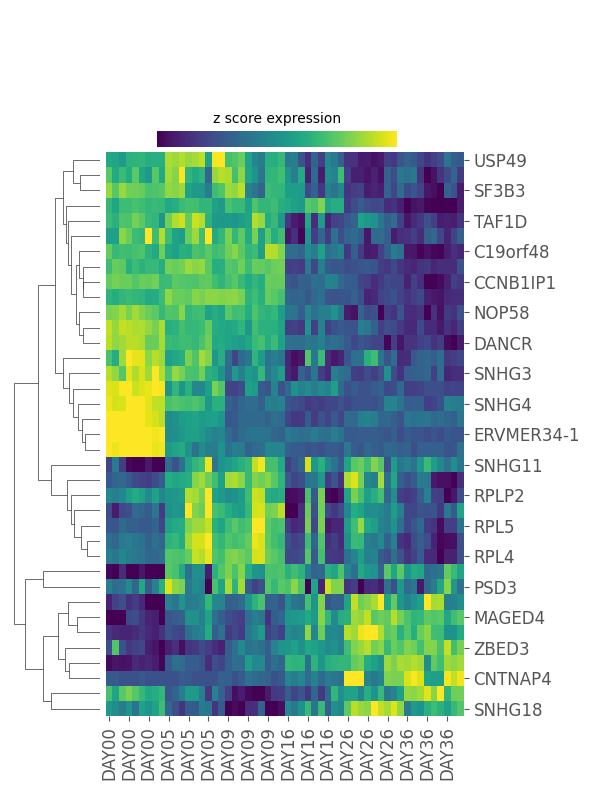

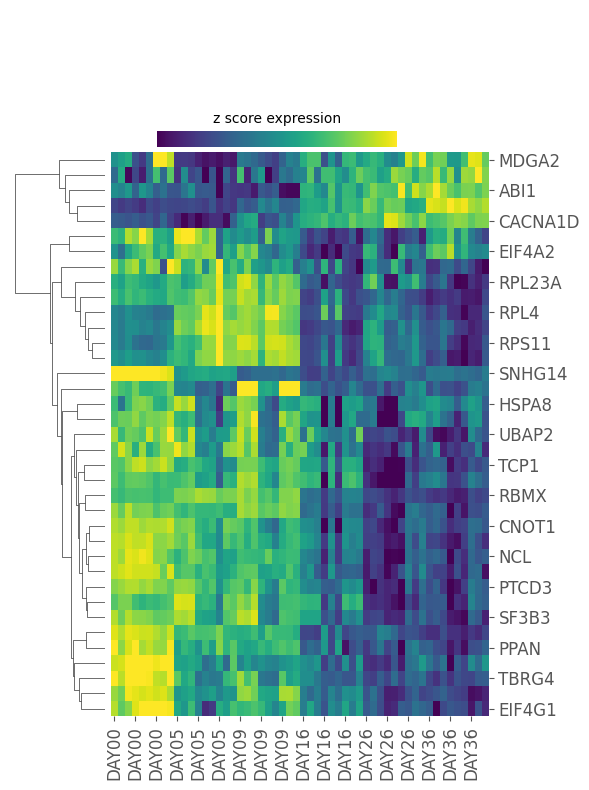

In [61]:
check_expression(z_df_mrna,correlated_genes["positive_gene"], "positive_regulated_sno.pdf", line = False, savefig = False)
check_expression(z_df_mrna,correlated_genes["negative_gene"], "negative_correlated_sno.pdf", line = False, savefig = False)

   cluster    Box  Host Symbol
0        1    C/D    44.444444
1        1  H/ACA    55.555556
   cluster    Box  Host Symbol
2        2    C/D    79.310345
3        2  H/ACA    20.689655
   cluster    Box  Host Symbol
4        3    C/D    11.864407
5        3  H/ACA    88.135593
   cluster    Box  Host Symbol
6        4    C/D    55.223881
7        4  H/ACA    44.776119
   cluster    Box  Host Symbol
8        5    C/D    20.967742
9        5  H/ACA    79.032258
    cluster    Box  Host Symbol
10        6    C/D         50.0
11        6  H/ACA         50.0


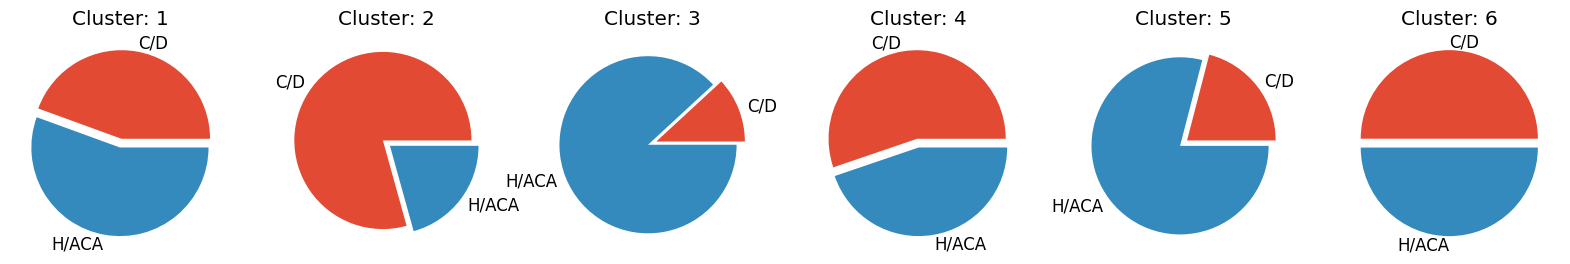

In [62]:
# make snoRNA analysis and retrieve distribution of the indiivdual cluster hAC and CD
snodb_cluster = pd.merge(snoRNA_cluster_table, snodb_selected, how = "left", left_index = True, right_index = True)
snodb_cluster = snodb_cluster.drop_duplicates().dropna()
snodb_clustering = snodb_cluster.groupby(["cluster","Box"]).count()
# groupby and calculate percentage
sno_db_final = snodb_clustering.groupby(level = 0).apply(lambda x:100 * x / float(x.sum()))
sno_db_trial = sno_db_final.reset_index()

fig,ax = plt.subplots(figsize = (20,5), ncols = 6, nrows = 1)
axes = 0
explode = (0.05, 0.05)
for i in sno_db_trial["cluster"].unique():
    circle_sno = sno_db_trial[sno_db_trial["cluster"]== i]
    print(circle_sno)
    if circle_sno.shape[0] > 1:
        ax[axes].pie(circle_sno["Host Symbol"], labels = circle_sno["Box"], explode = explode)
    else:
        ax[axes].pie(circle_sno["Host Symbol"], labels = circle_sno["Box"])
    ax[axes].set_title(f"Cluster: {i}")
    axes += 1

    #uncomment for saving
    #plt.savefig("snoRNA_distribution.pdf", dpi = 500, transparent = True, bbox_inches = "tight")

In [63]:
# analysis of hostgene circRNA
snoRNA_cluster_table[snoRNA_cluster_table["cluster"] == 3].head()

cluster
SNORA73B        3
SNORD14D        3
SNORD50B        3
SNORD15A        3
SNORD97         3

# WGCNA Analysis

In [55]:
# wgcna analysis data loaded here 
# DATALOADING
transcription_factor = pd.read_csv("../files/Transcripton_Factor_expression.csv").set_index("Unnamed: 0").T
gene_expression_module = pd.read_csv("../files/excerpt_RNA_merged_trnagene_expression_with_module_wo_mirna.csv").set_index("Row.names").drop("Unnamed: 0", axis = 1)
module_affiliation = pd.read_csv("../files/excerpt_RNA_merged_trnakME_wo_mirna_modules.csv")
module_eigenvector = pd.read_csv("../files/Eigenvector_modalities_wo_mirna.csv").set_index("Unnamed: 0").T

In [56]:
gene_expression_module["moduleLabels"].unique()

array(['purple', 'blue', 'yellow', 'turquoise', 'black', 'pink', 'brown',
       'greenyellow', 'magenta', 'grey', 'green', 'salmon', 'tan', 'cyan',
       'red'], dtype=object)

In [57]:
# retrieve the hub genes 
def get_hub_genes_per_module(kme_list, number_of_genes):
    """insert the kme_list and retrieve the hub gene based on the k-module eigenvector
    args:
        threshold (float) - > 0.8 should retrieve genes associated with the repsective kme
        number_of_genes (int) -> used for correlation analysis
    returns:
        hub_gene_dictionary(dict)-> dcit
    """
    
    columns = kme_list.columns
    hub_gene_dictionary = {}
    for i in columns:
        kme_list_inf = kme_list[[i]].sort_values(i, ascending = False)
        hub_gene_dictionary.update({i[3:] : [i.split(":")[0] for i in kme_list_inf.index.tolist()[:number_of_genes]]})

    return hub_gene_dictionary

In [59]:
hub_genes = get_hub_genes_per_module(module_affiliation.set_index("Unnamed: 0"), 25)

In [ ]:
# Network analysis of ncRNAs that are highly correlated based on soft threshold topology
# We further identified

nope not in list: purple
nope not in list: salmon
nope not in list: greenyellow
nope not in list: turquoise
Yes: blue
Yes: green
Yes: black
Yes: yellow
nope not in list: pink
nope not in list: cyan
nope not in list: tan
Yes: brown
nope not in list: magenta
Yes: red


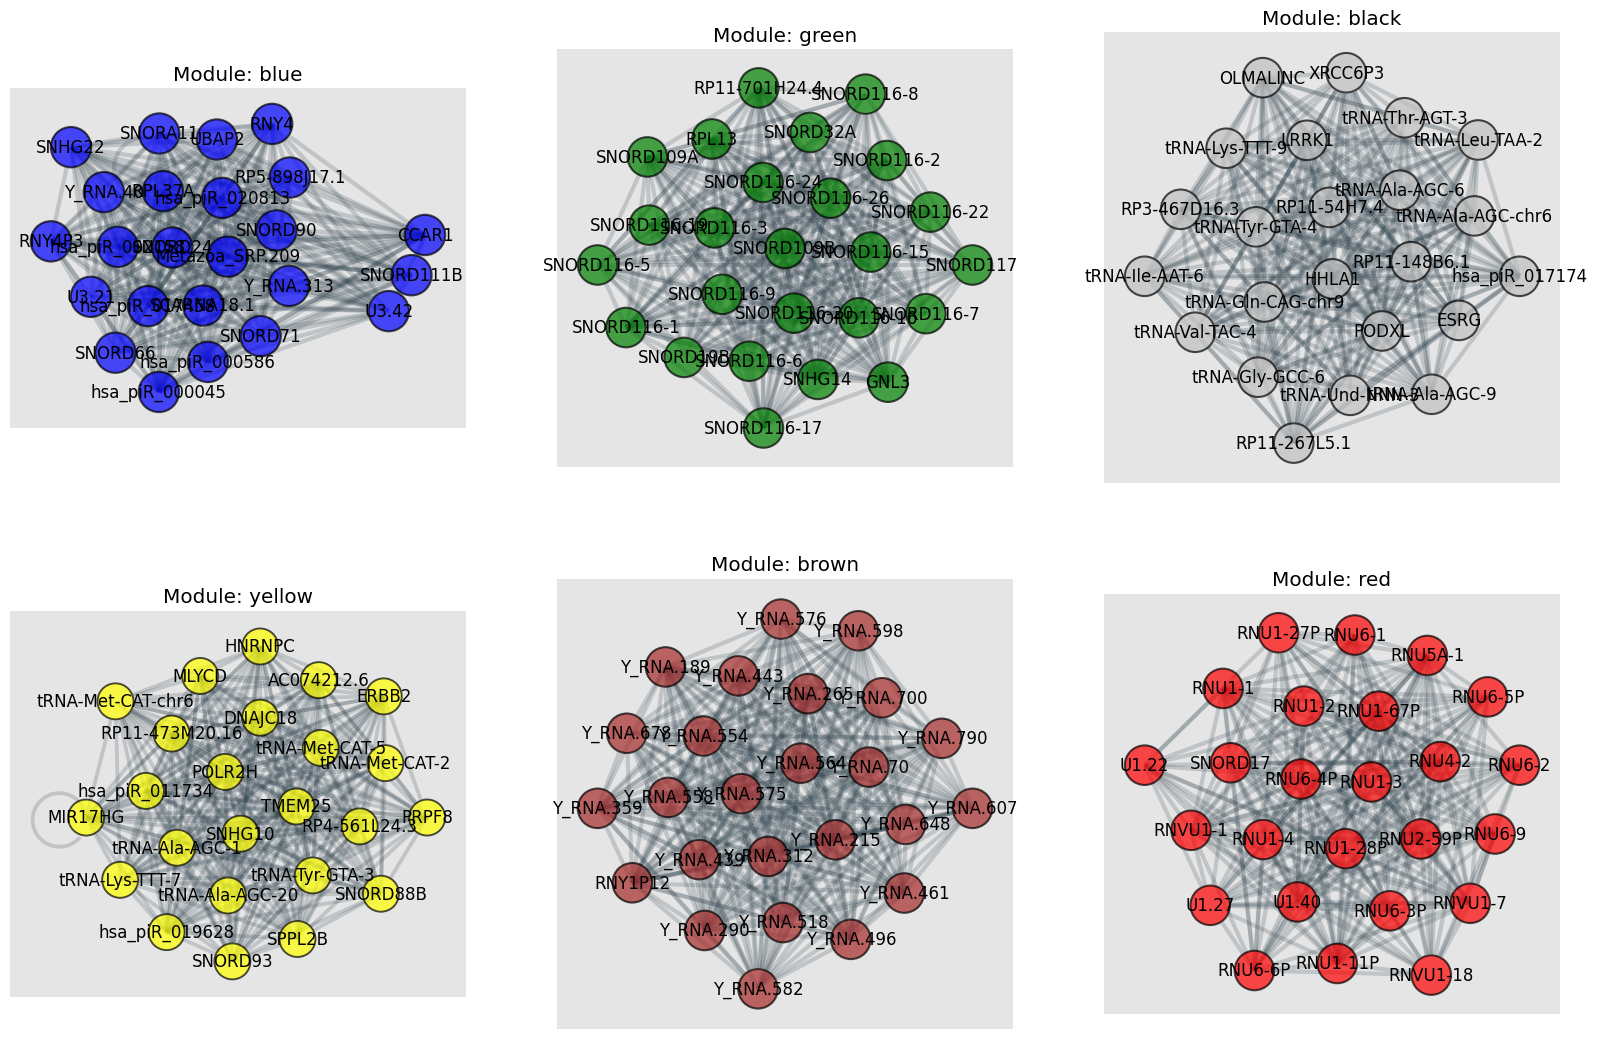

In [60]:
import netgraph as nt
import networkx as nx


def get_network_hubs(expression, top_hubs):
    """
    
    get the network_x modules for each WGCNA module
    based on correlation
    
    params:
    expression <- pd.DataFrame module gene expression
    top_hubs <- dict with top hubs per module
    
    output:
    networkx graphs
    
    """
    
    expression.index = [i.split(":")[0] for i in expression.index]
    axis_col = 0
    axis_row = 0
    list_modules = ["black","green","blue","yellow","brown","red"]
    
    fig,ax = plt.subplots(figsize = (20,13), ncols = 3, nrows = 2)
    
    # go through each module detect the correlation of the hub-genes within the
    # module and draw the network graph via conversion into adjacency matrix
    
    for module, hubs in top_hubs.items():
        if module != "grey": # grey module are genes that could not be associated
            
            #check of interesting modules
            if str(module) in list_modules:
                    print(f"Yes: {module}")
                    #retrieve the correlation matrix for each of the modules
                    expression_final = expression[expression.index.isin(hubs)]
                    expression_final.index = [i.split("|")[0] for i in expression_final.index]
                    expression_final = expression_final[expression_final["moduleLabels"] == module]
                    module_corr = expression_final.iloc[:,1:].T.corr()
                    
                    # unstack dataframe
                    stack_module = pd.DataFrame(module_corr.stack())
                    stack_module.index.set_names(["source", "target"], inplace=True)
                    stack_module = stack_module.reset_index()
                    stack_module.columns = ["source", "target", "score"] # set the columns
                    stack_module = stack_module[stack_module["score"] != 1] #remove genes correlation with themself
                    stack_module = stack_module[stack_module["score"] >= 0.7]

                    #draw the figure of the networks
                    module_net = nx.from_pandas_edgelist(stack_module, "source", "target", "score")
                    degree = module_net.degree()
                    values = [t for i, t in degree]
                    ax[axis_col, axis_row].set_title(f"Module: {module}")
                    if module == "black":
                        module = "silver"
    
                    
                    # draw the iGRaph object to detect
                    nt.Graph(module_net, 
                             node_color = module, 
                             node_layout = "spring", 
                             node_labels = True,
                             node_label_fontdict = {"size":12},
                             edge_size = 1,
                             node_size = 5,
                             node_edge_color = "black",
                             edge_alpha = 0.2,
                             node_alpha = 0.7,
                             ax = ax[axis_col, axis_row])
                    
                    
                    # draw the graph into the right axis field
                    if axis_row == 2:
                        axis_col += 1
                        axis_row = 0
                        
                    elif axis_row <2:
                        axis_row += 1
            else:
                print(f"nope not in list: {module}")
                
        plt.savefig("Network_WGCNA_modules_composition.pdf", dpi = 500, transparent = True, bbox_inches = "tight")
                        
            
get_network_hubs(gene_expression_module, hub_genes)

In [61]:
# concatenate the two dataframe fro a correlation matrix
transcription_factor.columns = module_eigenvector.columns
correlation = pd.concat([module_eigenvector, transcription_factor])# concat
correlation = correlation.T.corr()# use pearson correlation 
correlation = correlation.iloc[:10,10:] # slide to retrieve module transcription factor correlation
correlation = correlation.unstack().reset_index()
correlation.columns = ["tf", "module", "corr"]
correlation = correlation[correlation["corr"] > 0.85]

# Build the tf::ncRNA network 

/home/data-science/miniconda3/envs/miRNA_prediction/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:304: UserWarning: 

The connectionstyle keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default value for connectionstyle.
Note that using FancyArrowPatches may be slow for large graphs.

  draw_networkx_edges(G, pos, arrows=arrows, **edge_kwds)


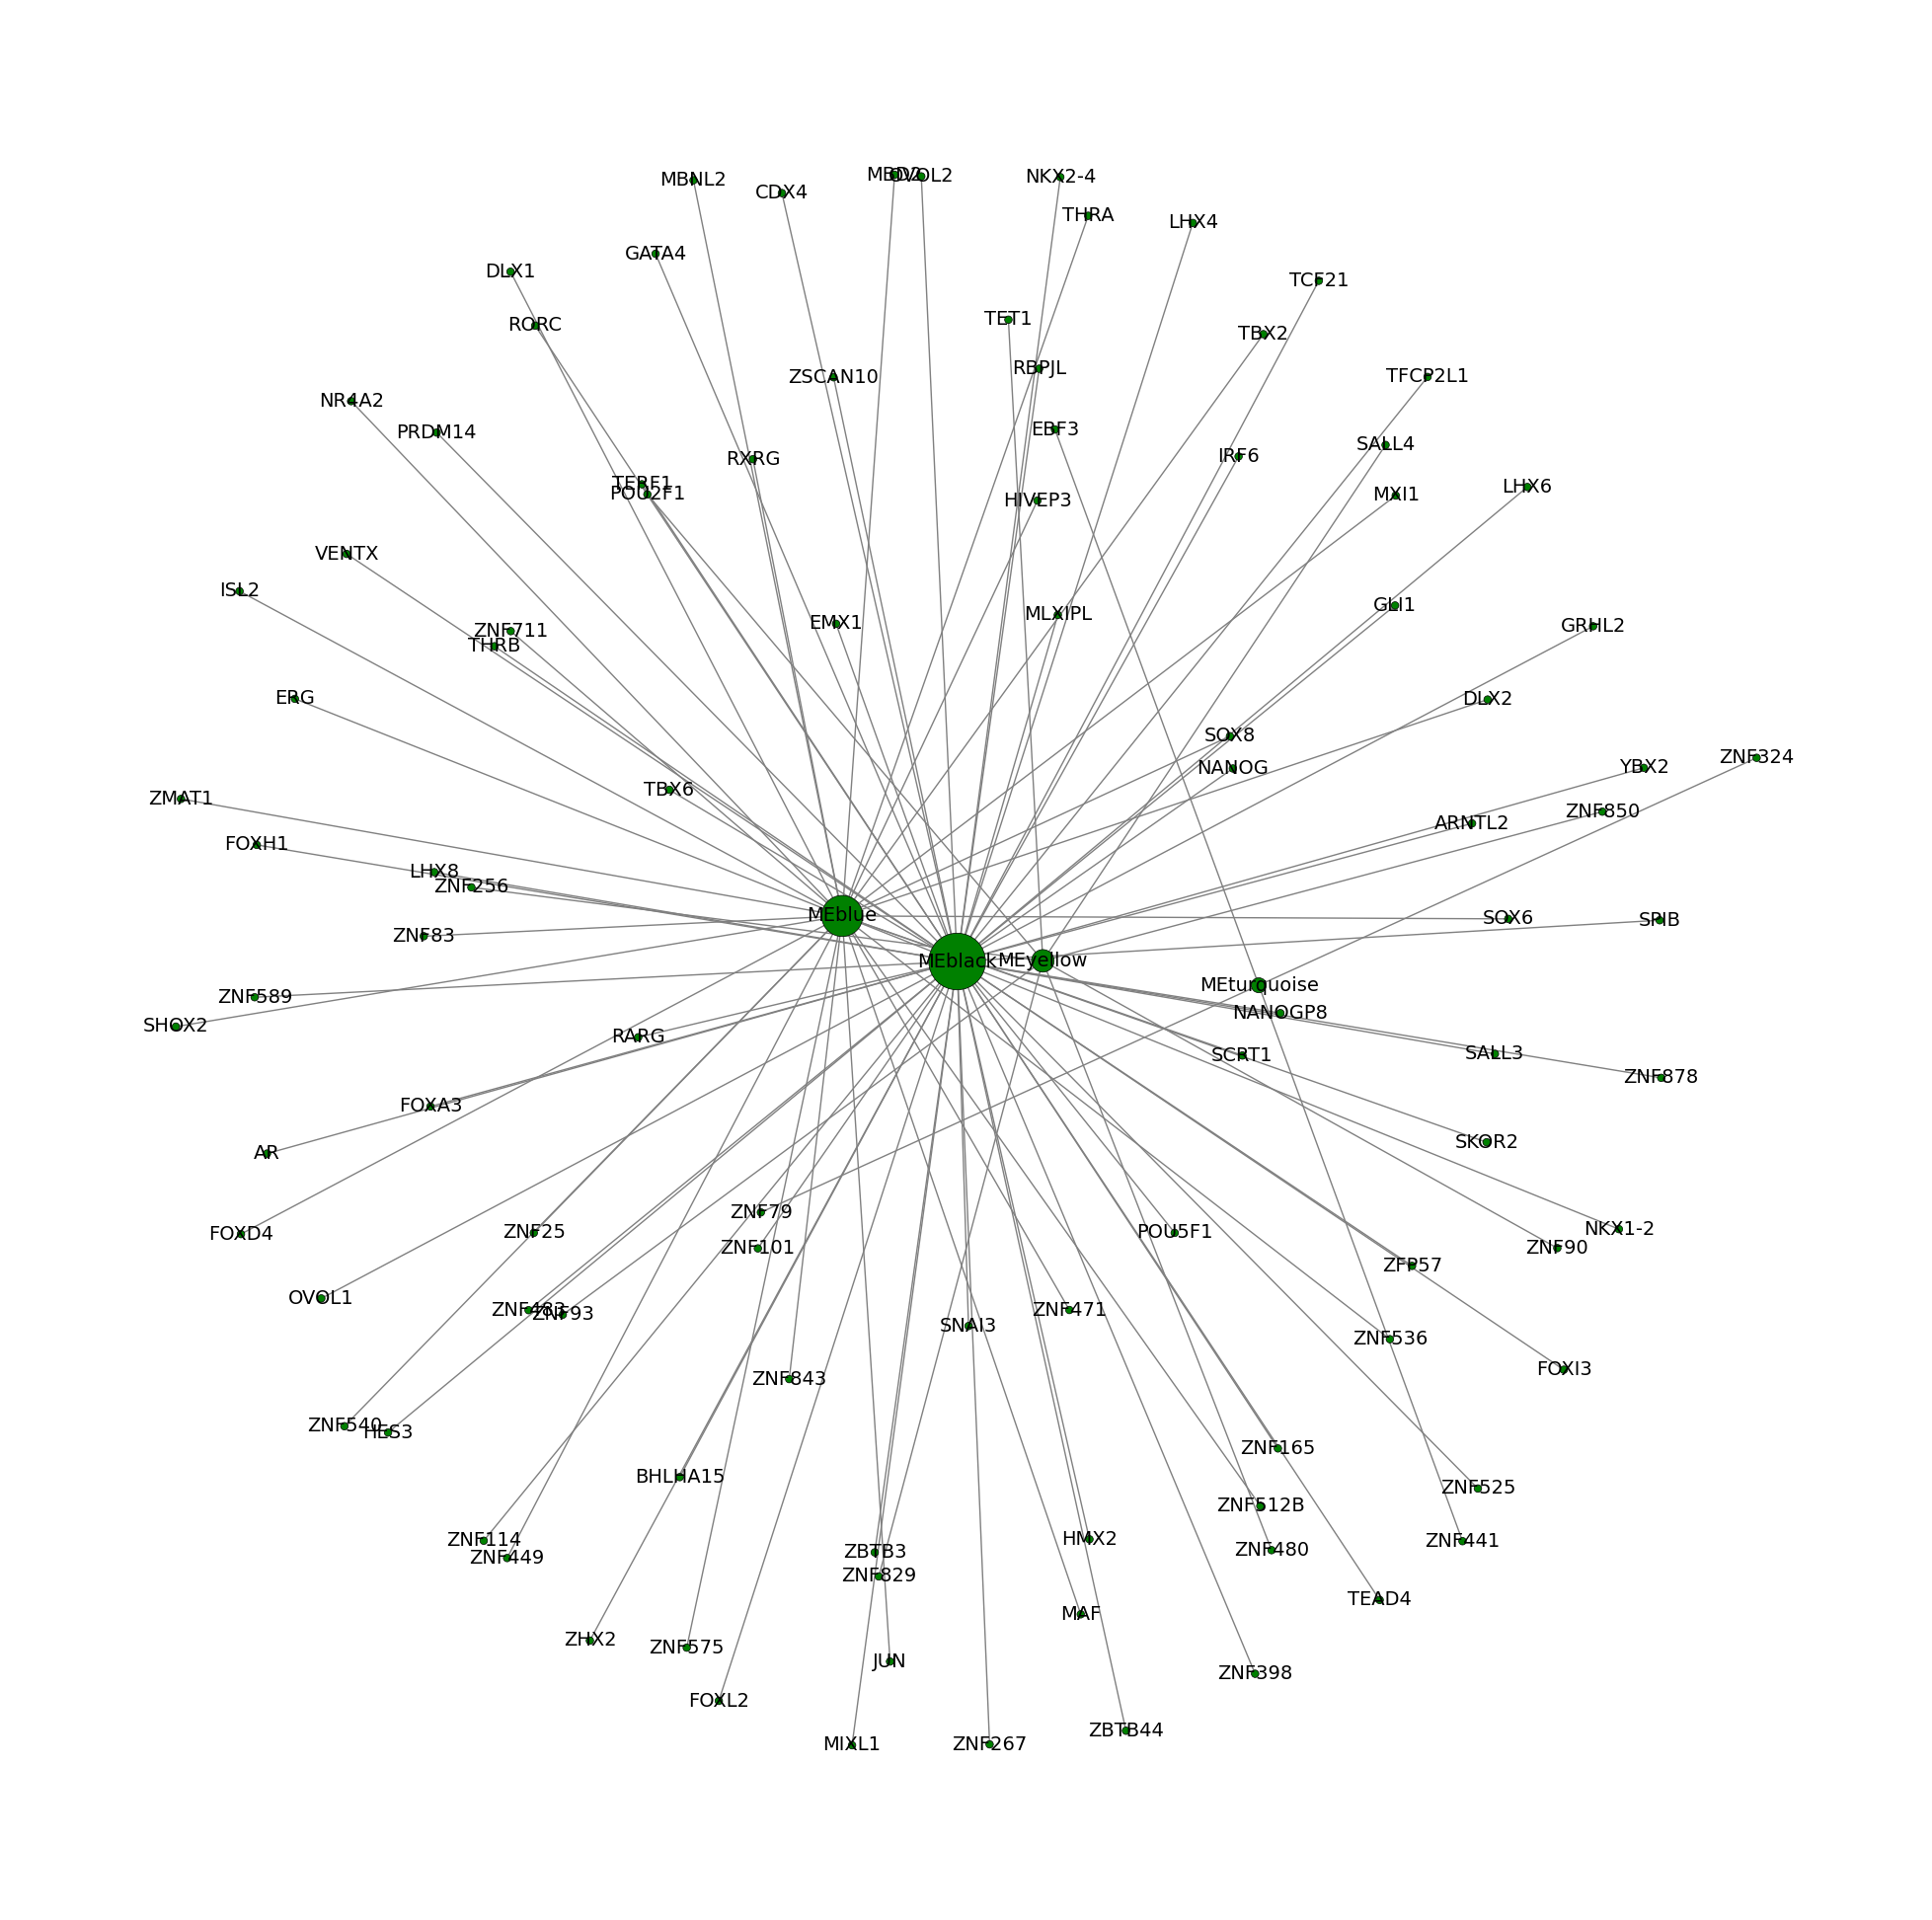

In [62]:
def network_module(corr):
    """Draws the module::tf networks 
    params:
    
    corr <- pd.DataFrame contains the unstacked correlations
    
    returns:
    
    network plot"""
    network = nx.from_pandas_edgelist(corr, "tf", "module", "corr")
    degree = network.degree()
    values = [t for i, t in degree]
    fig,ax = plt.subplots(figsize = (25,25))
    g = nx.draw_kamada_kawai(network,
                       with_labels=True,
                       node_color= "green",
                       node_size=[i * 30 for i in values],
                       edge_color="grey",
                       font_size=14,
                       connectionstyle='arc3, rad=0.4',
                       edgecolors = "black")
    
    # uncomment to save the network files of transcription factors for further analysis and drawing in gephy
    #nx.write_gexf(network,"network_ncrna_module_wo_mirna.gexf")
    #writing the network file for furthe gehpy processing
network_module(correlation)

# Basic transcription Factor Analysis

In [63]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
# make pca analysis for the samples
# no scaling necessary since this is already performed with vst counts
transformed_data_samples = pd.DataFrame(pca.fit_transform(transcription_factor.T))
transformed_data_samples["samples"] = colnames[1:]
transformed_data_samples.columns = ["PC1","PC2","Time"]
# run pca on gene level to estimate the most variable genes by pca loadings
transformed_data_genes = pd.DataFrame(pca.fit_transform(transcription_factor))
transformed_data_genes["Gene"] = transcription_factor.index
transformed_data_genes.columns = ["PC1","PC2", "Genes"]
transformed_data_genes
transformed_data_samples

PC1        PC2   Time
0   23.976841  18.911773  DAY00
1   23.994400  18.655366  DAY00
2   23.878513  18.260596  DAY00
3   17.738459 -11.188300  DAY05
4   17.506887 -10.862223  DAY05
5   17.854934 -10.525723  DAY05
6    5.555117 -15.396796  DAY09
7    5.020300 -14.757282  DAY09
8    5.344381 -15.122942  DAY09
9   -8.846543  -0.761478  DAY16
10  -9.043453  -0.716758  DAY16
11  -9.517154  -1.101043  DAY16
12 -17.829430   3.627948  DAY26
13 -17.360122   4.247647  DAY26
14 -18.166746   4.062530  DAY26
15 -18.004113   5.631105  DAY36
16 -17.758828   5.655351  DAY36
17 -18.907222   5.705903  DAY36
18  24.585217  19.220678  DAY00
19  24.619505  18.849878  DAY00
20  24.270852  19.512261  DAY00
21  17.457701 -11.145658  DAY05
22  17.403507 -11.494853  DAY05
23  17.463853 -11.245104  DAY05
24   4.565943 -14.549247  DAY09
25   3.757278 -14.607588  DAY09
26   2.645222 -14.854639  DAY09
27 -12.837149  -1.369287  DAY16
28  -8.845893  -1.592532  DAY16
29 -12.044810  -1.050750  DAY16
30 -18.658147   4.384261  DAY26
31 -18.694777   4.809027  DAY26
32 -17.395629   5.452453  DAY26
33 -19.546350   6.004022  DAY36
34 -18.892524   5.918796  DAY36
35 -18.552203   6.024752  DAY36
36  23.198021  18.041194  DAY00
37  23.025674  17.938078  DAY00
38  22.498214  17.965243  DAY00
39  14.281382 -13.742354  DAY05
40  17.246495 -13.548919  DAY05
41  17.701249 -14.053672  DAY05
42   4.728517 -16.236552  DAY09
43   4.845594 -16.149251  DAY09
44   4.537295 -16.095318  DAY09
45  -8.923535  -2.631731  DAY16
46  -9.269867  -2.229162  DAY16
47  -9.306042  -1.824465  DAY16
48 -15.930804   4.764788  DAY26
49 -16.753164   4.770922  DAY26
50 -15.600885   4.397634  DAY26
51 -17.020208   5.314353  DAY36
52 -17.515908   5.961097  DAY36
53 -18.479842   4.765972  DAY36

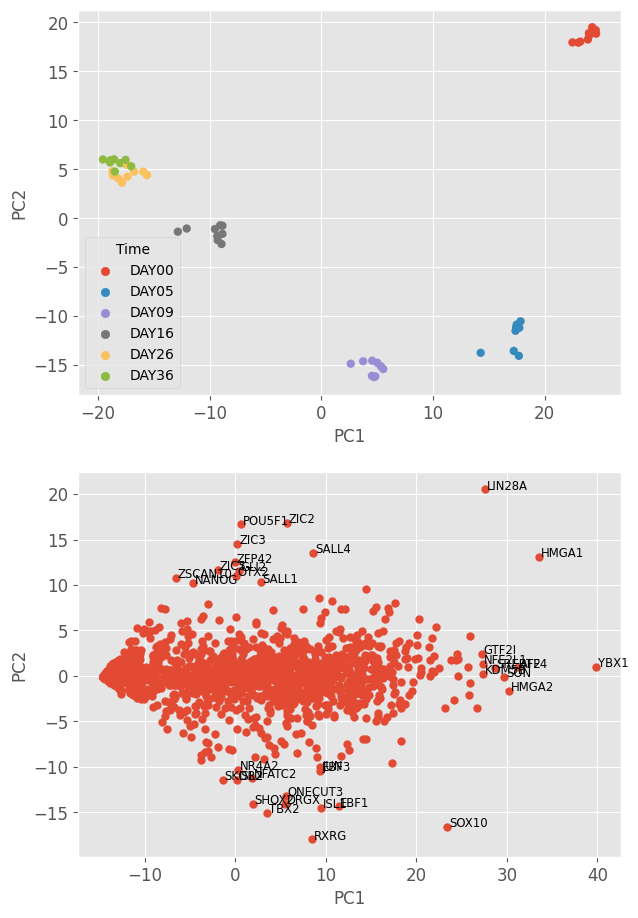

In [64]:
# Draw the Plots for the Supplements
fig,ax = plt.subplots(figsize = (7,11), ncols = 1, nrows = 2)
sns.scatterplot(data = transformed_data_samples, x= "PC1",y = "PC2", hue = "Time", ax = ax[0], linewidth = 0)
sns.scatterplot(data = transformed_data_genes, x= "PC1",y = "PC2", ax = ax[1], linewidth = 0)

#
for line in range(transformed_data_genes.shape[0]):
    if (abs(transformed_data_genes.PC2[line]) > 10) |  (abs(transformed_data_genes.PC1[line]) > 27):
        ax[1].text(transformed_data_genes.PC1[line]+0.2, transformed_data_genes.PC2[line], transformed_data_genes.Genes[line], horizontalalignment='left', size='small', color='black')
        
#plt.savefig("PCA_transcription_factors.pdf", dpi = 300)

/home/data-science/miniconda3/envs/miRNA_prediction/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


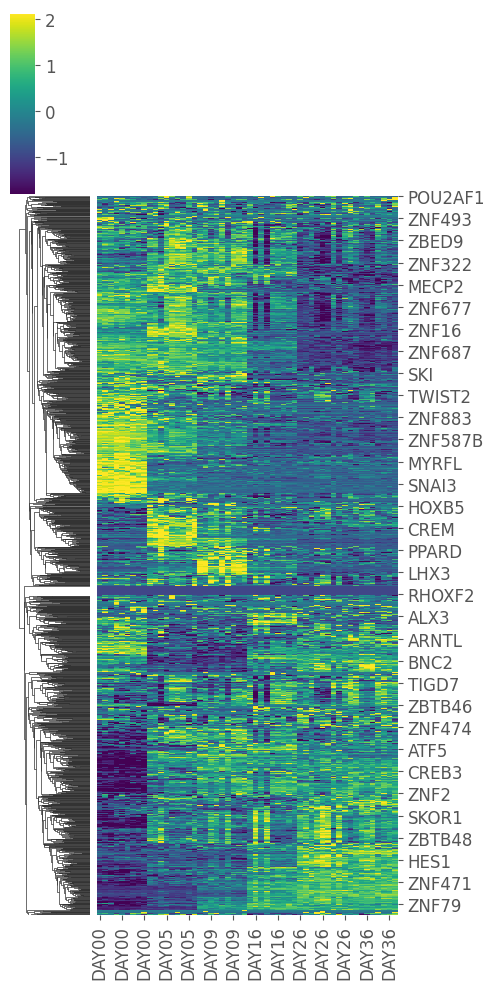

In [65]:
transcription_factor.columns = colnames[1:]
transcription_factor = transcription_factor.sort_index(axis = 1)
sns.clustermap(transcription_factor, z_score = 0, cmap = "viridis", robust = True, figsize = (5,10), col_cluster = False)

# lncRNA Analysis using lncSEA and retrieve table with significantly enriched miRNAs for groups clustered together

In [67]:
lnc_mirna = pd.read_csv("../files/lncrna_mirna_enrichment.csv")
lnc_mirna["log10p"] = lnc_mirna["FDR"].apply(lambda x: -(np.log10(x)))
lnc_mirna_index = lnc_mirna.set_index("Set")
lnc_mirna_index

Class Sub_Class  Count  \
Set                                          
hsa-let-7b-5p    MicroRNA   lncbase     14   
hsa-let-7f-5p    MicroRNA   lncbase     14   
hsa-let-7i-5p    MicroRNA   lncbase     14   
hsa-let-7g-5p    MicroRNA   lncbase     14   
hsa-let-7a-5p    MicroRNA   lncbase     14   
...                   ...       ...    ...   
hsa-miR-146b-5p  MicroRNA  starbase      4   
hsa-miR-101-3p   MicroRNA  starbase      4   
hsa-miR-148a-3p  MicroRNA  starbase      5   
hsa-miR-152-3p   MicroRNA  starbase      5   
hsa-miR-148b-3p  MicroRNA  starbase      5   

                                                            LncRNA  Simpson  \
Set                                                                           
hsa-let-7b-5p    FLVCR1-AS1;LINC00668;LINC00882;LINC00910;LOC10...   0.0476   
hsa-let-7f-5p    FLVCR1-AS1;LINC00668;LINC00882;LINC00910;LOC10...   0.0476   
hsa-let-7i-5p    FLVCR1-AS1;LINC00668;LINC00882;LINC00910;LOC10...   0.0476   
hsa-let-7g-5p    FLVCR1-AS1;LINC00668;LINC00882;LINC00910;LOC10...   0.0473   
hsa-let-7a-5p    FLVCR1-AS1;LINC00668;LINC00882;LINC00910;LOC10...   0.0471   
...                                                            ...      ...   
hsa-miR-146b-5p                KCNQ1OT1;NEAT1;MALAT1;RP11-159D12.2   0.2350   
hsa-miR-101-3p               GABPB1-AS1;NEAT1;MALAT1;RP11-452F19.3   0.2110   
hsa-miR-148a-3p    HOTAIRM1;KCNQ1OT1;KIF9-AS1;NUTM2A-AS1;LINC00667   0.1350   
hsa-miR-152-3p     HOTAIRM1;KCNQ1OT1;KIF9-AS1;NUTM2A-AS1;LINC00667   0.1350   
hsa-miR-148b-3p    HOTAIRM1;KCNQ1OT1;KIF9-AS1;NUTM2A-AS1;LINC00667   0.1320   

                      P-value       FDR  Bonferroni  Jaccard         %  \
Set                                                                      
hsa-let-7b-5p    3.530000e-07  0.000076    0.000337  0.01970    14/294   
hsa-let-7f-5p    3.530000e-07  0.000076    0.000337  0.01970    14/294   
hsa-let-7i-5p    3.530000e-07  0.000076    0.000337  0.01970    14/294   
hsa-let-7g-5p    3.820000e-07  0.000076    0.000364  0.01960    14/296   
hsa-let-7a-5p    3.980000e-07  0.000076    0.000380  0.01960    14/297   
...                       ...       ...         ...      ...       ...   
hsa-miR-146b-5p  6.080000e-05  0.000624    0.016800  0.00553  04/17/22   
hsa-miR-101-3p   9.690000e-05  0.000959    0.026800  0.00552  04/19/22   
hsa-miR-148a-3p  1.170000e-04  0.001080    0.032400  0.00674      5/37   
hsa-miR-152-3p   1.170000e-04  0.001080    0.032400  0.00674      5/37   
hsa-miR-148b-3p  1.340000e-04  0.001200    0.037100  0.00673      5/38   

                 Input_number  cluster    log10p  
Set                                               
hsa-let-7b-5p             504      D00  4.119758  
hsa-let-7f-5p             504      D00  4.119758  
hsa-let-7i-5p             504      D00  4.119758  
hsa-let-7g-5p             504      D00  4.119758  
hsa-let-7a-5p             504      D00  4.119758  
...                       ...      ...       ...  
hsa-miR-146b-5p           766  D26-D36  3.204815  
hsa-miR-101-3p            766  D26-D36  3.018181  
hsa-miR-148a-3p           766  D26-D36  2.966576  
hsa-miR-152-3p            766  D26-D36  2.966576  
hsa-miR-148b-3p           766  D26-D36  2.920819  

[505 rows x 13 columns]

In [68]:
lnc_mirna_grouped = lnc_mirna_index.groupby(["cluster"])["log10p"].nlargest(5).reset_index()
lnc_mirna_grouped_pivot = lnc_mirna_grouped.pivot(index = "cluster", columns = "Set", values = "log10p")
lnc_mirna_grouped_pivot = lnc_mirna_grouped_pivot.fillna(0)
lnc_mirna_grouped

cluster              Set     log10p
0       D00    hsa-let-7b-5p   4.119758
1       D00    hsa-let-7f-5p   4.119758
2       D00    hsa-let-7i-5p   4.119758
3       D00    hsa-let-7g-5p   4.119758
4       D00    hsa-let-7a-5p   4.119758
5   D00-D05   hsa-miR-195-5p   6.866461
6   D00-D05   hsa-miR-15a-5p   6.866461
7   D00-D05    hsa-miR-16-5p   6.866461
8   D00-D05   hsa-miR-424-5p   6.866461
9   D00-D05   hsa-miR-15b-5p   6.866461
10  D05-D09     hsa-miR-320a   7.261219
11  D05-D09  hsa-miR-1249-3p   7.122629
12  D05-D09      hsa-miR-940   6.478862
13  D05-D09  hsa-miR-181a-5p   6.478862
14  D05-D09  hsa-miR-449b-5p   6.067019
15  D16-D36   hsa-miR-185-5p   9.928118
16  D16-D36  hsa-miR-135a-5p   9.928118
17  D16-D36   hsa-miR-143-3p   9.379864
18  D16-D36   hsa-miR-369-3p   8.251812
19  D16-D36    hsa-miR-24-3p   6.812479
20  D26-D36   hsa-miR-26a-5p  15.739929
21  D26-D36   hsa-miR-369-3p  14.260428
22  D26-D36   hsa-miR-485-5p  12.823909
23  D26-D36   hsa-miR-574-5p  10.939302
24  D26-D36   hsa-miR-143-3p  10.939302

# Visualize miRNA_lncRNA interaction enrichments

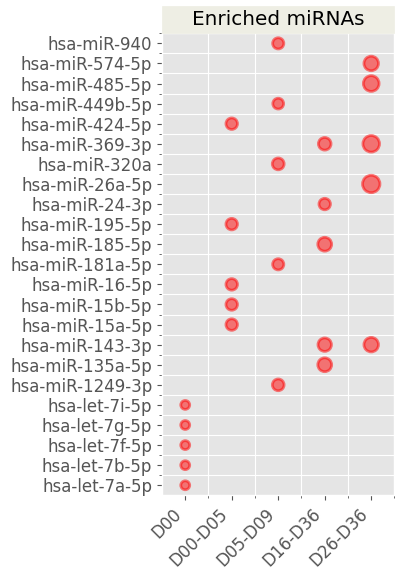

In [70]:
# draw a heatmap with the 
def value_to_color(val: float) -> str:
    """ Helper Function that converts values to colors
    Should be used to create a colormap 
    args:
        val()"""
    n_colors = 20 # Use 256 colors for the diverging color palette
    palette = sns.diverging_palette(0, 255, s=0, l=55, n=n_colors, center = "dark") # Create the palette
    color_min, color_max = [0,25] 
    val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
    ind = int(val_position * (n_colors - 1)) # target index in the color palette
    return palette[ind]


def heatmap(x, y, size, color):
    """make a heatmap that acts as a padj value plot
    Should be used to infer importance of miRNA targeting by lncRNA per timepoints
    
    args:
        x (pd.Series) <- x variable to draw usually the cluster/timepoint
        y (pd.Series) <- values
        size (pd.Series) <- column that is the marker for the dot size
        color (pd.Series) <- the hue of the data

        """
    plt.style.use('ggplot')
    fig, ax = plt.subplots(figsize = (3,6))

    # Mapping from column names to integer coordinates
    x_labels = [v for v in sorted(x.unique())]
    y_labels = [v for v in sorted(y.unique())]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)}
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 

    size_scale = 10
    ax.scatter(
        x=x.map(x_to_num), # Use mapping for x
        y=y.map(y_to_num), # Use mapping for y
        s=size * size_scale, # Vector of square sizes, proportional to size parameter
        color = "red",
        alpha = 0.5,
        linewidth = 2# Use square as scatterplot marker
    )

    # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)
    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5])
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
    bb = ax.set_title("Enriched miRNAs", backgroundcolor = "#eeeee4")
    bb._bbox_patch._mutation_aspect = 0.13
    bb.get_bbox_patch().set_boxstyle("square", pad=1.48)
    #plt.savefig("heatmap_enriched_mirnas_lncRNA.pdf", dpi = 300,bbox_inches = "tight")

# draw the heatmap
heatmap(
    x=lnc_mirna_grouped['cluster'],
    y=lnc_mirna_grouped['Set'],
    size=lnc_mirna_grouped['log10p'].abs(),
    color = lnc_mirna_grouped['log10p']
)


In [75]:
# get the trajectories of the top 10 miRNAS per group
all_expression = pd.read_csv("../files/all_nc_RNA_-vsd.csv").set_index("Unnamed: 0")
all_expression = z_score_dataset(all_expression)
#def get_trajectories(grouped_dataframe, expression):
all_expression.columns = colnames[1:]
# sort column index 
all_expression = all_expression.sort_index(axis = 1).reset_index()
all_expression

index     DAY00     DAY00     DAY00     DAY00     DAY00  \
0       5S_rRNA.16-201  0.554896  0.067192 -1.413533  0.927987  1.335623   
1       5S_rRNA.29-201  0.996864  1.222899  1.323503  1.707784  2.083745   
2      5_8S_rRNA.1-201  2.486388  0.325358  0.230921  0.689448  2.279748   
3      5_8S_rRNA.2-201  0.301354 -0.180351 -3.571040  0.502855 -0.117906   
4      5_8S_rRNA.3-201 -0.982666 -1.859881  0.015576  0.540262  0.378804   
...                ...       ...       ...       ...       ...       ...   
22280    hsa-piR-30995 -0.137361 -0.137361 -0.137361 -0.137361 -0.137361   
22281    hsa-piR-32124 -0.137361 -0.137361 -0.137361 -0.137361 -0.137361   
22282     hsa-piR-4656 -0.137361 -0.137361 -0.137361 -0.137361 -0.137361   
22283     hsa-piR-5953 -0.137361 -0.137361 -0.137361 -0.137361 -0.137361   
22284     hsa-piR-7469 -0.137361 -0.137361 -0.137361 -0.137361 -0.137361   

          DAY00     DAY00     DAY00     DAY00  ...     DAY26     DAY36  \
0      0.891526  0.848450  1.308822  0.370076  ...  1.094804 -0.244173   
1      2.083177  1.277365  1.884869  2.395636  ... -0.738720 -0.579655   
2      0.521560  0.221997  0.089176 -0.064376  ... -0.244267 -1.205543   
3      1.726457 -0.409602  1.222112 -0.535874  ...  0.174584  1.655644   
4     -0.310315  0.760654  0.138708 -0.249593  ... -1.304963  0.695993   
...         ...       ...       ...       ...  ...       ...       ...   
22280 -0.137361 -0.137361 -0.137361 -0.137361  ... -0.137361 -0.137361   
22281 -0.137361 -0.137361 -0.137361 -0.137361  ... -0.137361 -0.137361   
22282 -0.137361 -0.137361 -0.137361 -0.137361  ... -0.137361 -0.137361   
22283 -0.137361 -0.137361 -0.137361 -0.137361  ... -0.137361 -0.137361   
22284 -0.137361 -0.137361 -0.137361 -0.137361  ... -0.137361 -0.137361   

          DAY36     DAY36     DAY36     DAY36     DAY36     DAY36     DAY36  \
0      1.662708  0.633128  1.051332  1.602933  1.999231  0.362693  1.174244   
1     -0.662297 -0.669057 -0.864208 -0.845151 -0.766775 -0.778412 -0.688741   
2     -0.062224 -1.234932 -0.685024 -0.713343 -1.490328  0.070627  2.665002   
3     -0.208555 -0.271665 -1.471730 -0.250525  1.200335 -0.346603 -0.455304   
4      0.455959  0.396577  0.269928  0.094631 -1.286657 -0.013832 -0.967913   
...         ...       ...       ...       ...       ...       ...       ...   
22280 -0.137361 -0.137361 -0.137361 -0.137361 -0.137361 -0.137361 -0.137361   
22281 -0.137361 -0.137361 -0.137361 -0.137361 -0.137361 -0.137361 -0.137361   
22282 -0.137361 -0.137361 -0.137361 -0.137361 -0.137361 -0.137361 -0.137361   
22283 -0.137361 -0.137361 -0.137361 -0.137361 -0.137361 -0.137361 -0.137361   
22284 -0.137361 -0.137361 -0.137361 -0.137361 -0.137361 -0.137361 -0.137361   

          DAY36  
0      1.370929  
1     -0.576815  
2     -1.134811  
3      1.232836  
4     -0.775369  
...         ...  
22280  7.280110  
22281  7.280110  
22282  7.280110  
22283  7.280110  
22284  7.280110  

[22285 rows x 55 columns]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


                 index     DAY00     DAY00     DAY00     DAY00     DAY00  \
0       5S_rRNA.16-201  0.554896  0.067192 -1.413533  0.927987  1.335623   
1       5S_rRNA.29-201  0.996864  1.222899  1.323503  1.707784  2.083745   
2      5_8S_rRNA.1-201  2.486388  0.325358  0.230921  0.689448  2.279748   
3      5_8S_rRNA.2-201  0.301354 -0.180351 -3.571040  0.502855 -0.117906   
4      5_8S_rRNA.3-201 -0.982666 -1.859881  0.015576  0.540262  0.378804   
...                ...       ...       ...       ...       ...       ...   
22280    hsa-piR-30995 -0.137361 -0.137361 -0.137361 -0.137361 -0.137361   
22281    hsa-piR-32124 -0.137361 -0.137361 -0.137361 -0.137361 -0.137361   
22282     hsa-piR-4656 -0.137361 -0.137361 -0.137361 -0.137361 -0.137361   
22283     hsa-piR-5953 -0.137361 -0.137361 -0.137361 -0.137361 -0.137361   
22284     hsa-piR-7469 -0.137361 -0.137361 -0.137361 -0.137361 -0.137361   

          DAY00     DAY00     DAY00     DAY00  ...     DAY26     DAY36  \
0      0.8915

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


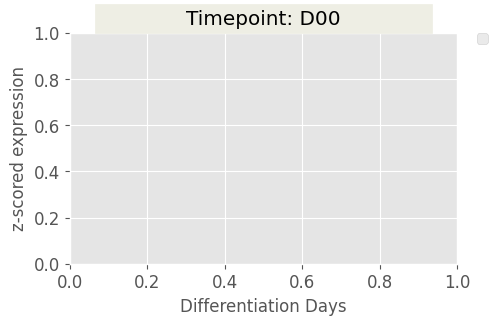

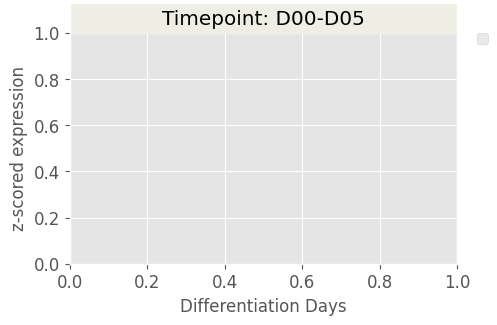

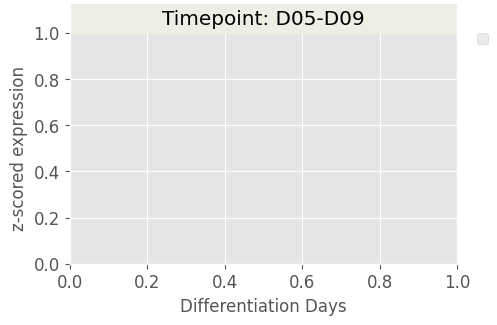

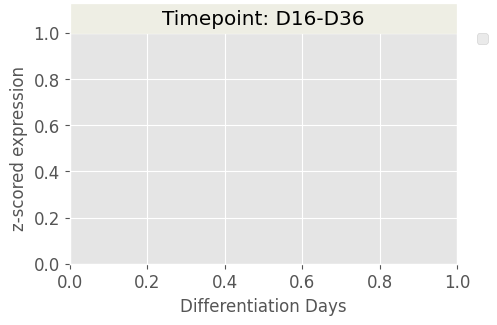

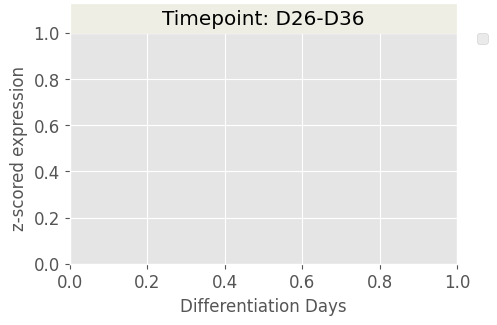

In [76]:
def get_trajectories_mirna(vsd_counts: pd.DataFrame, grouped_df: pd.DataFrame) -> None:
    """ draw the miRNA trajectories for the timepoints as predicted by the lncSEA 
    algorithm
    arg:
        vsd_counts(pd.DataFrame) <- data haveing the z-scored vst counts
        grouped_df (pd.DataFrame)<- the grouped dataframe holding the miRNAs
        """
    print(vsd_counts)
    for i in grouped_df["cluster"].unique():
        cluster_mirna = grouped_df[grouped_df["cluster"] == i]["Set"].tolist()
        expression = vsd_counts[vsd_counts.index.isin(cluster_mirna)].reset_index()
        melt_expression = pd.melt(expression, id_vars = "index")
        fig,ax = plt.subplots(figsize = (5,3))
        sns.lineplot(x = "variable", y = "value", hue = "index", data = melt_expression)
        plt.xlabel("Differentiation Days")
        plt.ylabel("z-scored expression")
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        bb = ax.set_title(str(f"Timepoint: {i}"), backgroundcolor = "#eeeee4")
        bb._bbox_patch._mutation_aspect = 0.055
        bb.get_bbox_patch().set_boxstyle("square", pad=4.55)
        plt.savefig(f"lnc_miRNA_{i}_trajectory.pdf", dpi = 300,bbox_inches = "tight")

get_trajectories_mirna(all_expression, lnc_mirna_grouped)